# 미국 중고차 가격 예측
- 조대선, 홍성현, 배준영, 유호원

# 가설
- 주행거리 5만킬로 미터 이하일때 파는게 좋을것이다.
- 지역별 가격차이가 있을것이다.
- 경제위기가 왔을때, 중고차 가격에 영향이 있을것이다.

# 현재 진행상황
- 데이터 전처리
- EDA
- 모델링


## 데이터 출처
- Craigslist(크레이그리스트) https://craigslist.org/ : 중고 매물, 구인 구직, 주택, 자유 주제 토론등을 다루는 커뮤니티 웹사이트
- 미국내 중고차 매물 약 51만 건(업데이트 : 2020년 1월)
- 데이터 출처 : https://www.kaggle.com/austinreese/craigslist-carstrucks-data (캐글)
- Craigslist Filter 웹 애플리케이션(https://craigslist-filter.herokuapp.com/)
- 웹 애플리케이션 github : https://github.com/AustinReese/craigslistFilter (github)


<img src="./img/img2.png" width="1200">

In [298]:
import re
import missingno as msno
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.5f}'.format

<img src="./img/img6.png" width="1200">

# 슬라이드쇼 할때 코드 안보이게 하는 코드

In [297]:
from IPython.display import HTML

HTML('''
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# 표, 마크다운 글씨 크기 조절

In [299]:
%%html
<style>
table {float:left}
table td, table th {
        border-style: solid;
        font-size: 25px;
}
li {
    font-size: 35px;
    margin:5px;
}
</style>


## 컬럼 정보

|컬럼명|내용|설명|
|:------|:---|:---|
|<span style= 'background:yellow'> **price** </span> | **entry price** |  **중고차 가격**|
|<span style= 'background:pink'>**year**</span> | **entry year** | **중고차 연식**|
|<span style= 'background:pink'>**manufacturer**</span> |  **manufacturer of vehicle**| **제조사**|
|<span style= 'background:pink'>**cylinders**</span> |  **number of cylinder** | **엔진 기통수** |
|<span style= 'background:pink'>**fuel**</span> |  **fuel type** | **연료타입** |
|<span style= 'background:pink'>**odometer**</span> |  **miles traveled by vehicle**| **총주행거리**|
|<span style= 'background:pink'>**title_status**</span> |  **title status of vehicle** |**차량 상태**|
|<span style= 'background:pink'>**transmission**</span> |  **transmission of vehicle**| **미션**|
|<span style= 'background:pink'>**vin**</span> |  **vehicle identification numbe**| **차대번호**|
|<span style= 'background:pink'>**drive**</span> |  **type of drive** |**구동방식**|
|<span style= 'background:pink'>**size**</span> |  **size of vehicle** | **차량크기**|
|<span style= 'background:pink'>**type**</span> |  **generic type of vehicle**| **차량 타입**|
|<span style= 'background:pink'>**paint_color**</span> |  **color of vehicle**| **차량 색상**|
|<span style= 'background:pink'>**state**</span> |  **state of listing**| **주 명**|

### **예측에 도움이 되지 않는 데이터**
|컬럼명|내용|설명|
|:------|:---|:---|
|condition |  condition of vehicle|차량 상태||
|lat|  latitude of listing| 위도|
|long |  longitude of listing| 경도|
|url |  listing  | 중고차 등록 URL |
|region |  craigslist region | 중고차 거래 지역|
|region_url |  region URL | 중고차 지역 정보 URL|
|image_url |  image URL | 중고차 사진 URL|
|size |  size of vehicle | 차량 크기, 결측치 50% 이상|
|condition |  condition of vehicle| 차량 상태, 결측치 45% 이상|
|description |  listed description of vehicle|  중고차 상태 설명|
|county |  useless column left in by mistake | 행정 구역 단위 (데이터 없음)|
|model |  model of vehicle| 차량 모델명, 다른 feature들의 대표성을 띄는 데이터 (다중 공선성 발생)|

# 데이터 탐색

## 전처리

In [2]:
raw_data = pd.read_csv("vehicles.csv")

In [3]:
start_df = raw_data[['id','price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders','vin']]

In [4]:
start_df.shape

(509577, 14)

### 결측치 확인

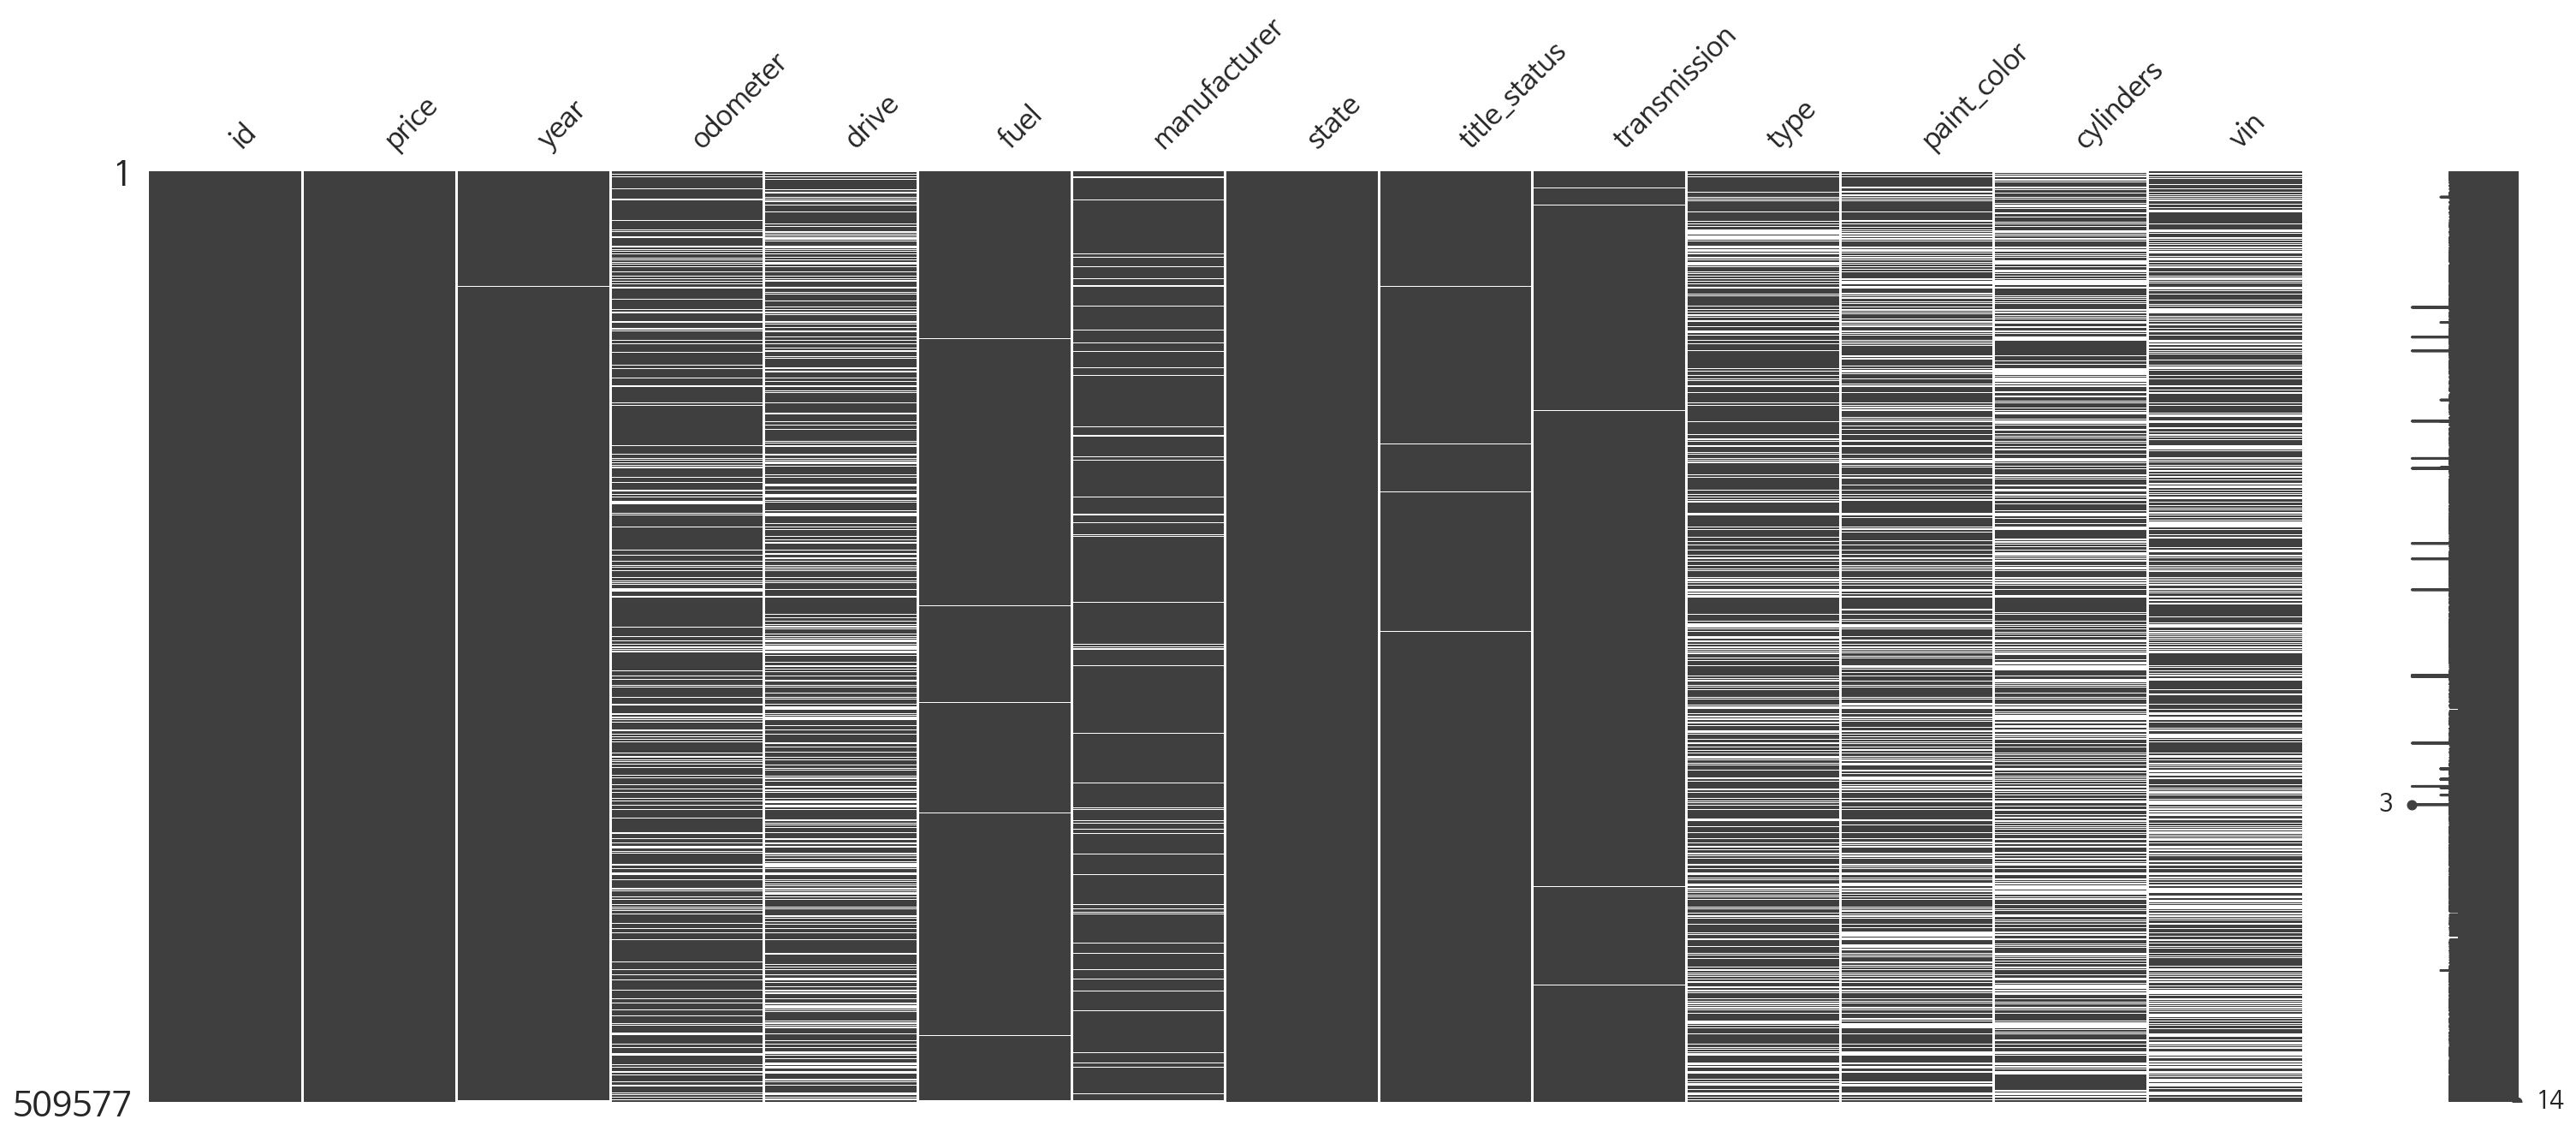

In [7]:
msno.matrix(start_df)
plt.show()

#### 결측치 수치화

In [8]:
def columns_na_percentage(columns):
    for column in columns:
        percentage = round(100 -(len(raw_data['{}'.format(column)].dropna()) / len(raw_data)) * 100,2)
        if percentage :
            print("{} : ".format(column), percentage,"%",end='\n')

In [9]:
columns_na_percentage(start_df.columns)

year :  0.3 %
odometer :  18.12 %
drive :  28.29 %
fuel :  0.78 %
manufacturer :  4.47 %
title_status :  0.6 %
transmission :  0.73 %
type :  27.77 %
paint_color :  32.32 %
cylinders :  39.19 %
vin :  40.71 %


#### 결측치 제거 

In [10]:
start_df = start_df.dropna(axis=0)
start_df.shape

(120609, 14)

## 차대 번호(vin)를 활용한 데이터 필터링

- **Step1**
    - 중복된 'vin'을 가지고 있는 데이터 삭제

In [11]:
df = start_df.loc[start_df['vin'].drop_duplicates(keep='last').index]
df.shape

(77678, 14)

- **Step2**
    - 'vinaudit.com'이 제공하는 api를 이용
     <img src="./img/img1.png" width="850" style="float:left">

- **데이터 출처**
    - 자동차 이력 제공시스템 : (NMVTIS/National Motor Vehicle Title Information System)
    - 미국 도로교통 안전국 : (NHTSA / National Highway Traffic Safety Administration)
    - 미국 교통부 연방차량안전국 : (Federal Motor Carrier Safety Administration, FMCSA) 
    - 그외 미국 정부 기관과 관련된 업체 및 파트너사

## 크롤링 데이터 분석

|컬럼명|설명|
|:------|:---|
| **above** | 최대 가격|
|**average** | 평균 가격|
|**below** | 최소 가격 |
|**certainty** | 정확도 |
|**count**|  거래 횟수|
|**error** |  에러 메세지 |
|**mileage**|  주행 거리 |
|**period**|  거래 시기|
|**stdev**|  표준 편차|
|**success**|  성공 여부|
|**vehicle**|  차량 정보 (연식, 제조사, 모델명)|

<img src="./img/img3.png" width="800">

- **데이터 사용처**
    - Vincheck등 중고차 매물 검색 업체
<img src="./img/img5.png" width="250">    
    - NICB (National Insurance Crime Bureau) 등
<img src="./img/img4.png" width="200">

### 크롤링 데이터를 활용한 데이터 필터링

In [12]:
vin_crawling_data = pd.read_csv('./final_vin_crawling.csv')

# 대문자 변경
vin_crawling_data['vin'] = vin_crawling_data['vin'].str.upper()

# 중복제거
vin_crawling_data_drop_dupli = vin_crawling_data.drop_duplicates('vin',keep='first')

# 대문자 변경
df['vin'] = df['vin'].str.upper()

# merge
final = pd.merge(df,vin_crawling_data_drop_dupli,on='vin')

# 중복 제거
final_drop_dupli = final.drop_duplicates('vin',keep='first')

df = final_drop_dupli[final_drop_dupli.columns.difference(['id_y','Unnamed: 0','Unnamed: 0.1','og_vin'])]
df.shape

(77569, 26)

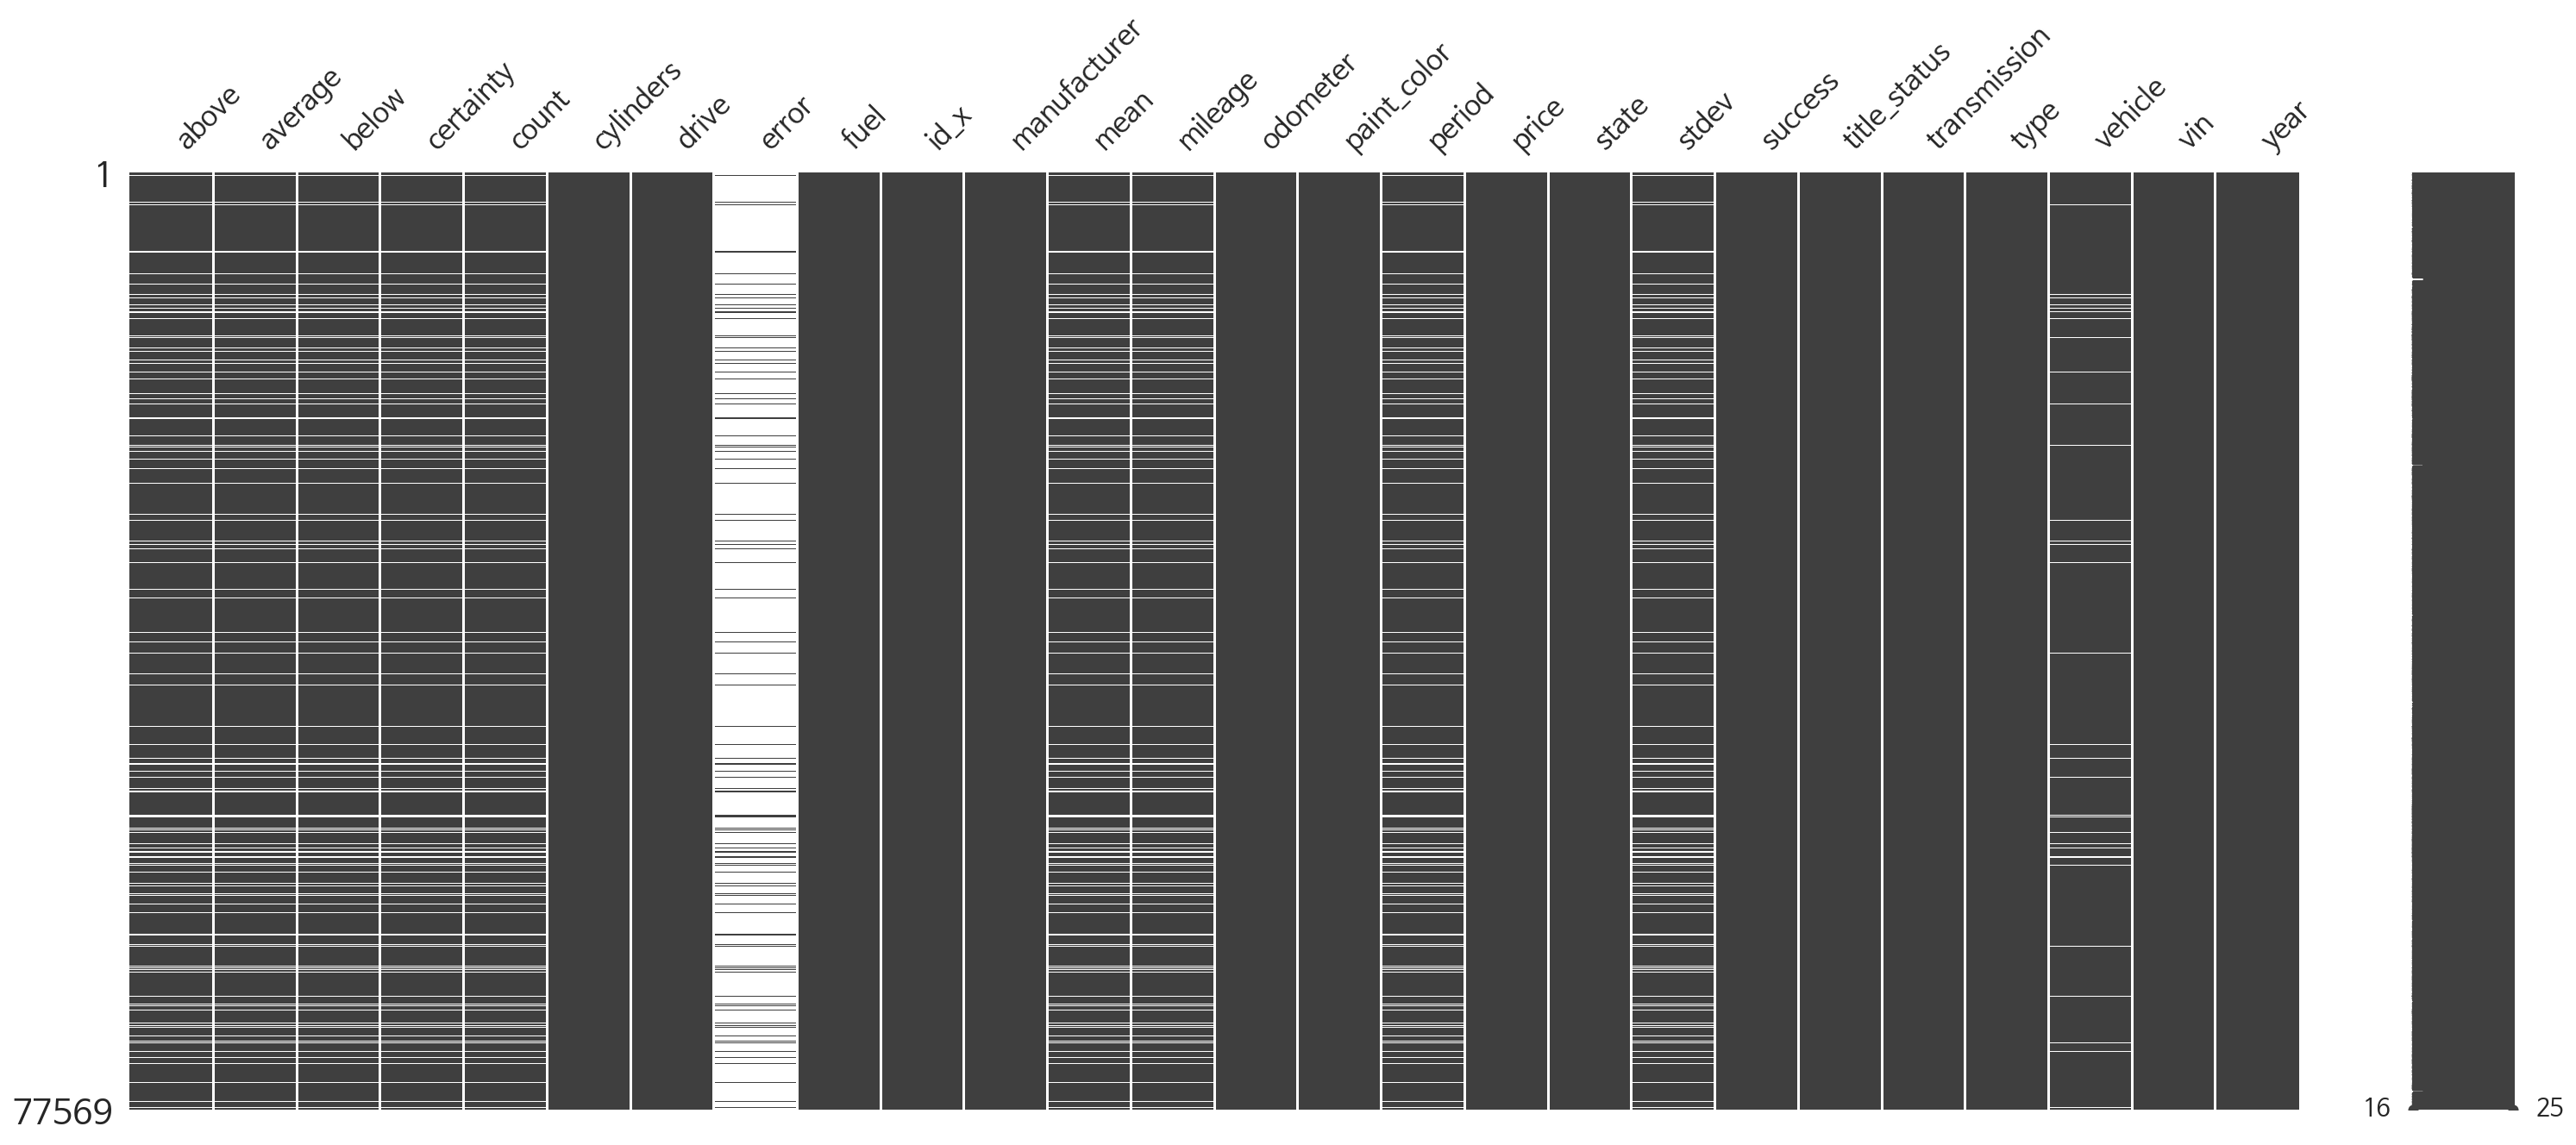

In [13]:
msno.matrix(df)
plt.show()

### error 컬럼 
- 'no_data' : request시에 던져준 'odometer'가 잘못되어 정보를 가져올수 없는 경우, 즉 이력조회가 되지않는 차량
- 'invalid_vin' : request시에 던져준 'vin'이 17자리가 아닌 경우
  - 1980년도 이전에 생산된 차량의 정보는 데이터베이스화 되어있지 않음
  - 판매자가 잘못된 vin값을 입력한 경우

In [17]:
df['error'].value_counts()

no_data        4263
invalid_vin    3038
Name: error, dtype: int64

- 'error'값을 가지고 있는 row들을 제거

In [201]:
test=df[df.columns.difference(['error'])]

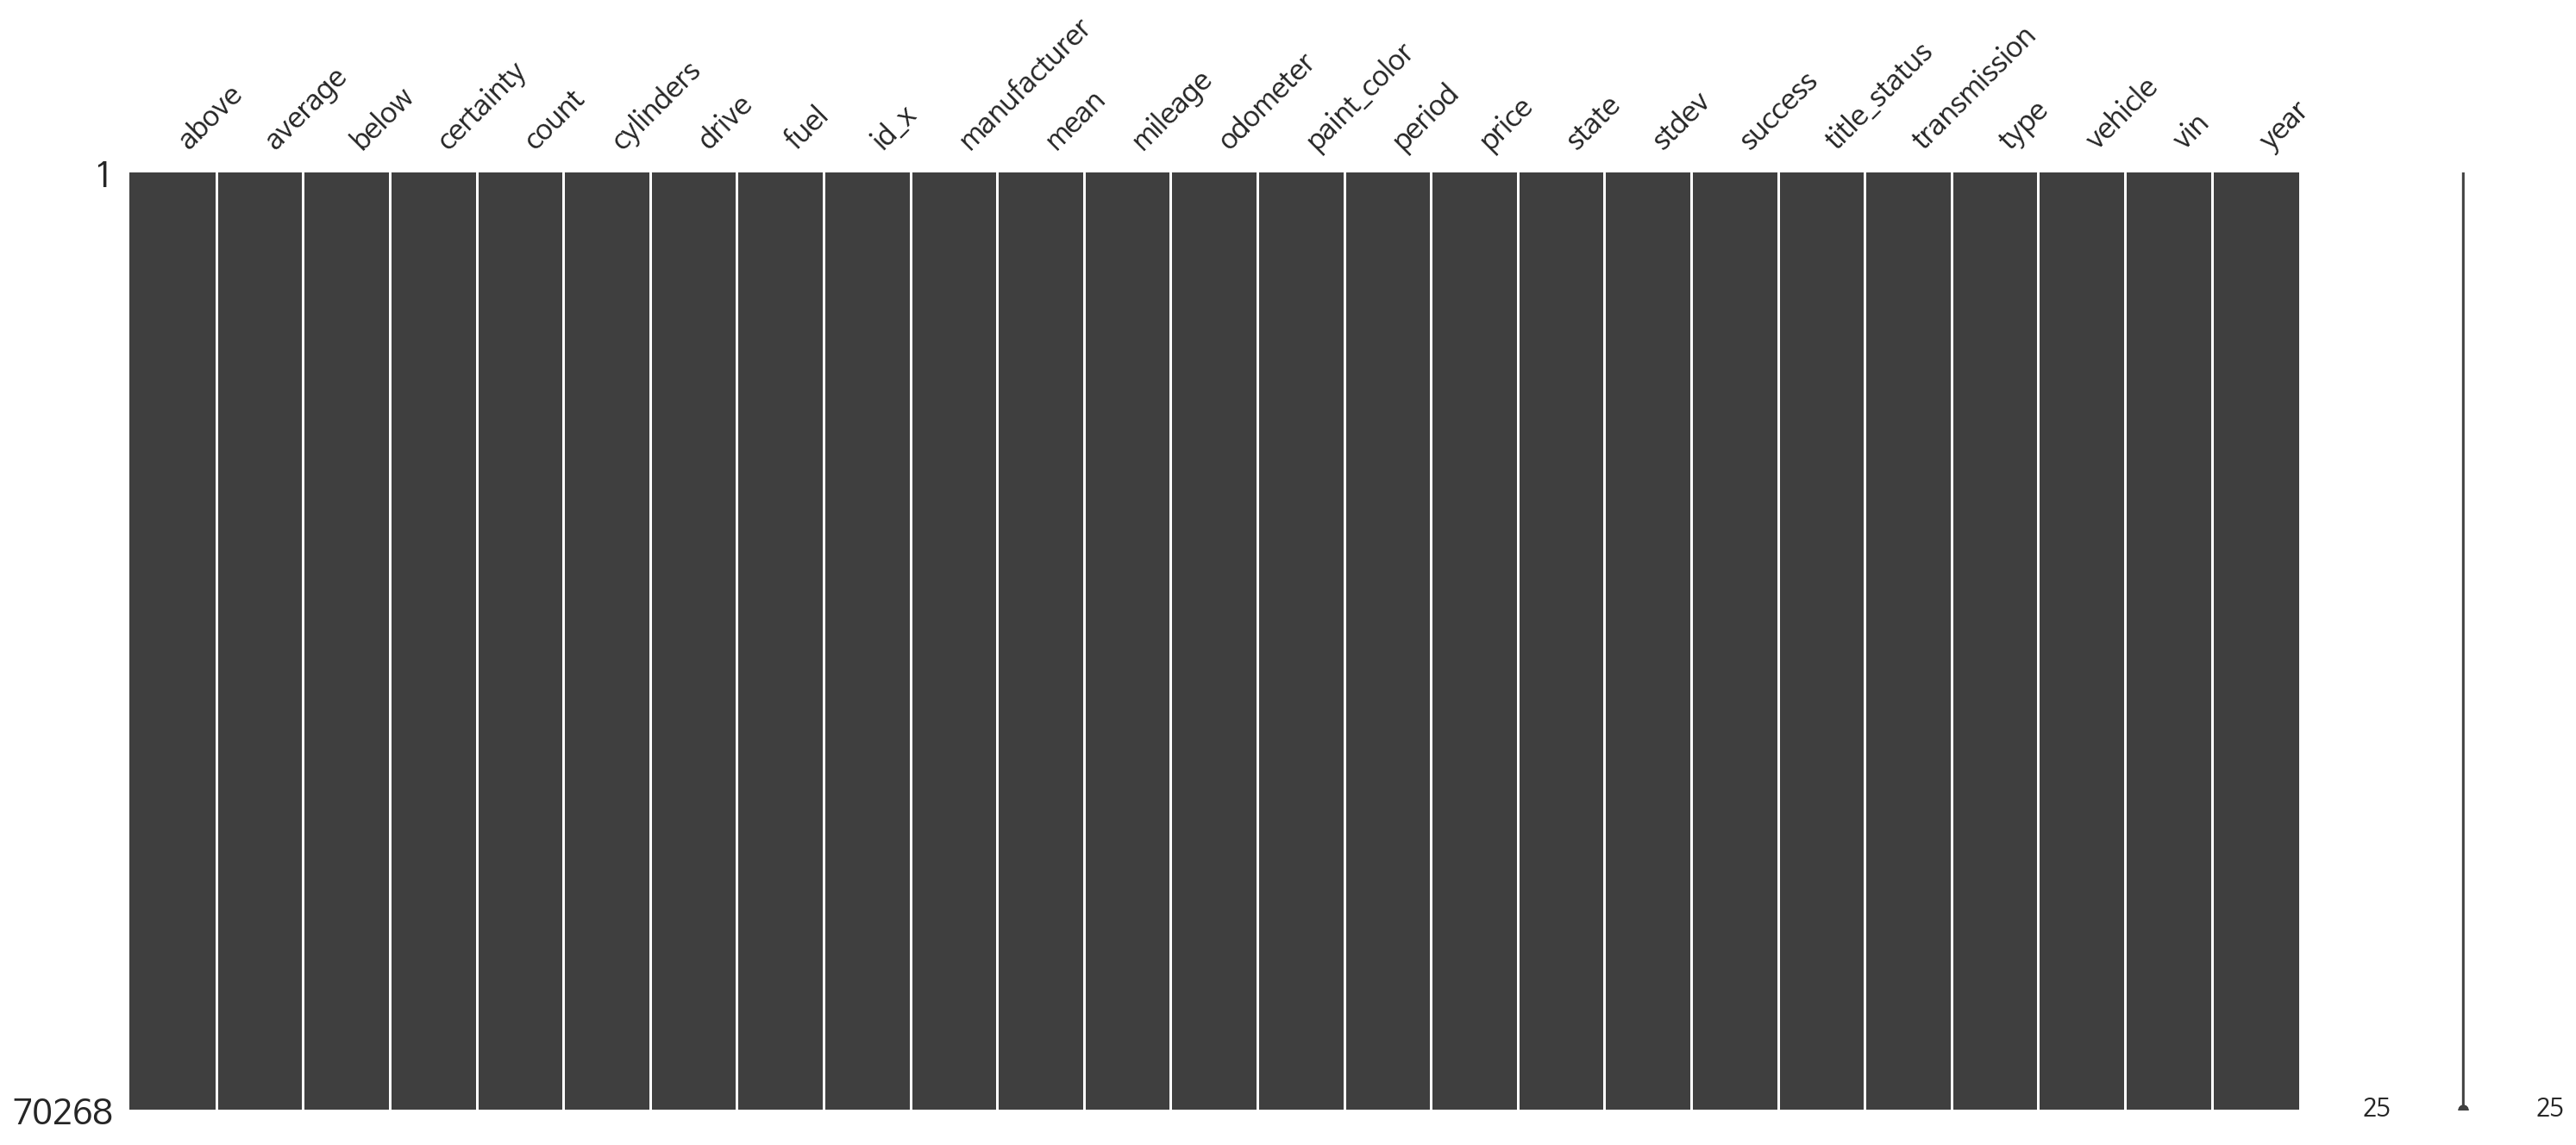

In [202]:
test = test.dropna(axis=0)
msno.matrix(test)
plt.show()

# 아웃라이어 탐색

### 가격 아웃라이어 탐색

- 평균가격과 표준편차를 이용해 'price'의 아웃라이어를 필터링

In [203]:
test[['above', 'average', 'below','stdev']].head(2)

,above,average,below,stdev
0,20878.90000,18399.90000,15920.90000,2479.00000
1,8113.75000,6710.75000,5307.75000,1403.00000


### 평균값과 표준편차를 이용한 데이터 필터링

In [240]:
def get_sigma_data_by_price(num):
    # price가 0인것들 제거
    test2 = test[(test['price'] >= (test['average'] - (test['stdev']*num))) & (test['price'] <= (test['average'] + (test['stdev']*num)))]
    print("{} sigma data : ".format(num),test2.shape)
    return test2

In [335]:
test2 = get_sigma_data_by_price(2)
test2.shape

2 sigma data :  (56026, 25)


(56026, 25)

In [336]:
# year를 int로 형변환
test2['year'] = test2['year'].astype('int')

### 주행거리 아웃라이어 탐색
- odometer와 mileage가 다른 데이터 : 판매자가 과도하게 높은 odometer를 입력한 경우

In [337]:
print("주행거리가 잘못 입력된 차량 대수 : ",len(test2[test2['mileage'] != test2['odometer']]))
test2[test2['mileage'] != test2['odometer']].sort_values(ascending=False,by='odometer').head(2)

주행거리가 잘못 입력된 차량 대수 :  31


,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
51426,10244.99000,8898.99000,7552.99000,81.70000,9.00000,6 cylinders,4wd,gas,7046006501,lexus,8898.99000,148490.00000,4706000.00000,custom,"['2019-10-02', '2020-03-07']",8000,nc,1346.00000,True,clean,automatic,SUV,2007 Lexus RX 400h Base,JTJHW31UX72010051,2007
8407,5276.60000,4335.60000,3394.60000,65.00000,4.00000,8 cylinders,4wd,gas,7034479993,dodge,4335.60000,180265.00000,4000085.00000,custom,"['2019-10-05', '2020-01-15']",3995,al,941.00000,True,clean,automatic,SUV,2004 Dodge Durango SLT,1D4HB48N44F169643,2004


In [338]:
# 주행거리 아웃라이어 제거
test2 = test2[test2['mileage'] == test2['odometer']]

### 박스플롯, 스캐터 플롯

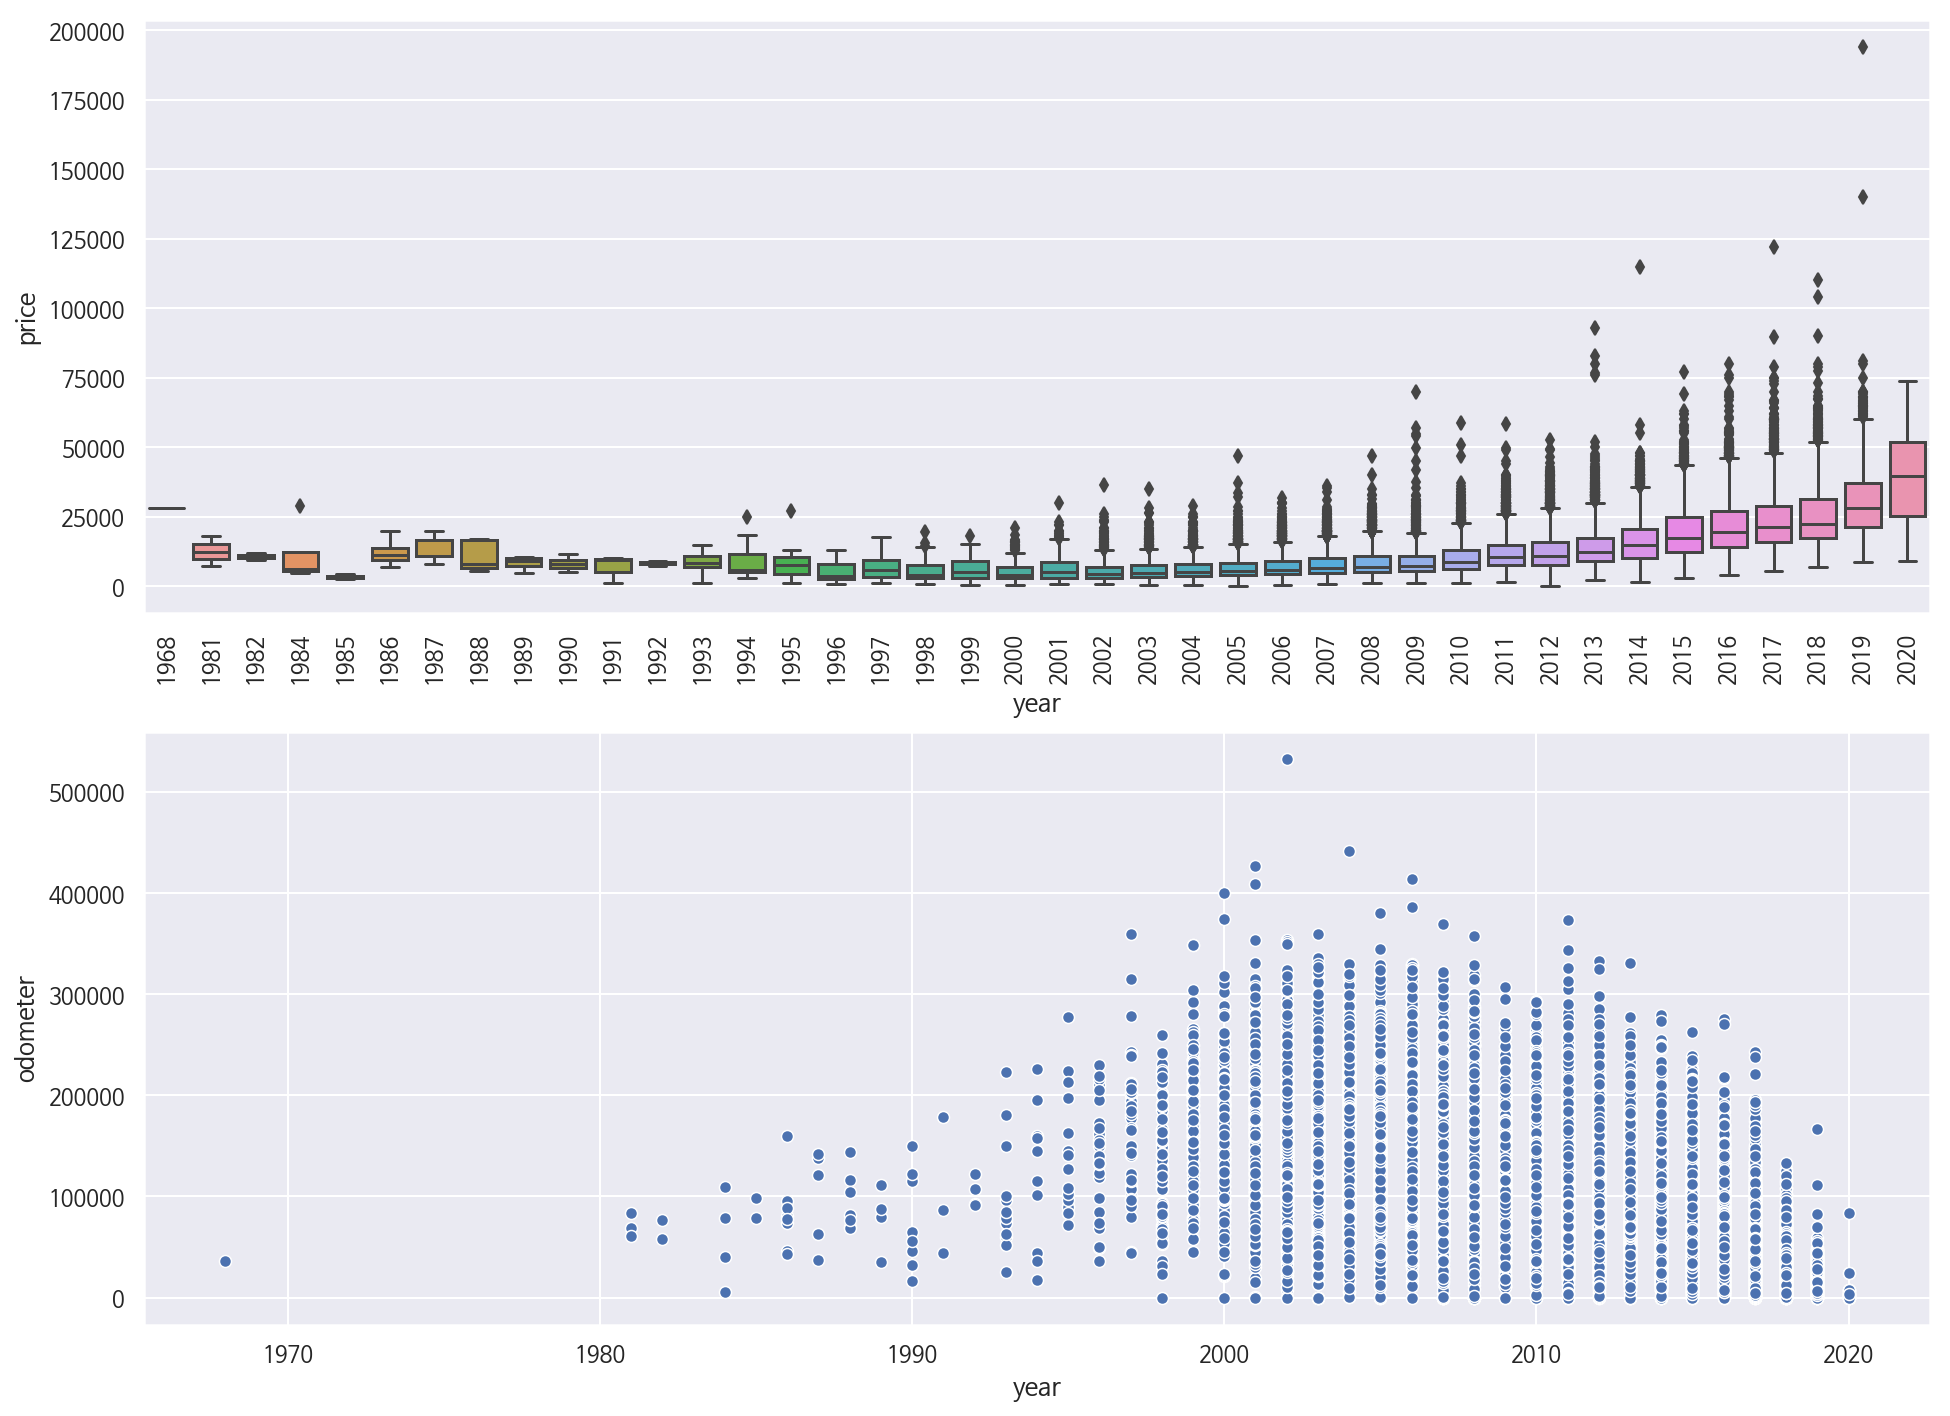

In [339]:
plt.figure(figsize=(16,12))
plt.subplot(211)
sns.boxplot(x="year", y="price", data = test2)
plt.xticks(rotation=90)
plt.subplot(212)
sns.scatterplot(test2['year'],test2['odometer'])
# plt.subplot(313)
# sns.scatterplot(test2['year'],test2['price'])

plt.show()

## 플롯 그린후 눈으로 본 데이터

- 연도

In [340]:
# year 수정해 줘야 하는 데이터
test2[test2['year'] < 1980]

,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
49431,31752.09000,28691.09000,25630.09000,99.00000,240.00000,8 cylinders,rwd,gas,7035287698,pontiac,28691.09000,36211.00000,36211.00000,blue,"['2019-12-14', '2020-03-26']",27988,mt,3061.00000,True,clean,automatic,other,2019 Toyota Sienna,5TDYZ3DC0KS008940,1968


In [341]:
test2['year'] = test2['year'].apply(lambda x : 2019 if x < 1980 else x)

- 주행거리

In [342]:
test2[test2['odometer'] > 500000]

,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
28776,9045.70000,6984.70000,4923.70000,65.00000,4.00000,8 cylinders,4wd,gas,7044009302,toyota,6984.70000,533000.00000,533000.00000,grey,"['2019-10-03', '2020-02-20']",6500,ga,2061.00000,True,clean,automatic,SUV,2002 Toyota Land Cruiser Base,JTEHT05J722017912,2002


In [343]:
# 약 18년간 운행한 자동차의 일 평균 주행거리 계산
print("평균 주행거리 : ", round(533000.00 / (365* 18),2),"마일/day")

평균 주행거리 :  81.13 마일/day


- 가격
  - 75000불 초과 차량 확인

In [344]:
test2[test2['price'] > 75000].sort_values(by=['price'],ascending=False).head()

,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
60128,202032.56000,182660.56000,163288.56000,90.00000,16.00000,8 cylinders,4wd,gas,7045671330,mercedes-benz,182660.56000,7584.00000,7584.00000,white,"['2019-10-03', '2020-03-26']",193982,oh,19372.00000,True,clean,automatic,SUV,2019 Mercedes-Benz,WDCYC7HJ3KX301396,2019
29627,149400.58000,132238.58000,115076.58000,70.30000,5.00000,3 cylinders,4wd,hybrid,7048009986,bmw,132238.58000,649.00000,649.00000,grey,"['2019-10-05', '2020-03-14']",139995,hi,17162.00000,True,clean,automatic,convertible,2019 BMW,WBY2Z6C52KVB82784,2019
20351,130595.38000,124912.38000,119229.38000,79.60000,8.00000,10 cylinders,4wd,gas,7049707044,audi,124912.38000,25624.00000,25624.00000,red,"['2019-10-06', '2020-03-19']",121995,co,5683.00000,True,clean,automatic,coupe,2017 Audi R8 (V10 quattro),WUAEAAFX4H7901309,2017
10976,125445.67000,119893.67000,114341.67000,74.20000,6.00000,8 cylinders,rwd,gas,7043599850,ferrari,119893.67000,12986.00000,12986.00000,black,"['2019-10-03', '2020-03-22']",114950,az,5552.00000,True,clean,automatic,convertible,2014 Ferrari California Base,ZFF65TJAXE0200770,2014
73531,117293.94000,105051.94000,92809.94000,90.70000,17.00000,8 cylinders,rwd,gas,7047378977,mercedes-benz,105051.94000,5560.00000,5560.00000,black,"['2019-10-01', '2020-03-26']",109995,tx,12242.00000,True,clean,automatic,convertible,2018 Mercedes-Benz AMG GT Base,WDDYK7HA6JA014263,2018


- 500불 미만 차량 확인

In [345]:
test2[test2['price'] < 500].sort_values(by=['price'],ascending=False)

,above,average,below,certainty,count,cylinders,drive,fuel,id_x,manufacturer,mean,mileage,odometer,paint_color,period,price,state,stdev,success,title_status,transmission,type,vehicle,vin,year
22916,1708.69000,1139.69000,570.69000,57.30000,3.00000,4 cylinders,4wd,gas,7037527384,honda,1139.69000,380774.00000,380774.00000,silver,"['2020-02-21', '2020-03-11']",390,de,569.00000,True,clean,automatic,sedan,2005 Honda Civic LX,2HGES16695H615734,2005
39176,280.57000,242.57000,204.57000,44.30000,2.00000,8 cylinders,fwd,gas,7040987260,lincoln,242.57000,180000.00000,180000.00000,red,"['2019-11-01', '2019-12-04']",300,la,38.00000,True,clean,automatic,sedan,1999 Lincoln Continental Base,1LNHM97V3XY629191,1999
38722,18636.20000,12424.20000,6212.20000,44.30000,2.00000,8 cylinders,rwd,other,7037057151,chevrolet,12424.20000,158389.00000,158389.00000,white,"['2019-10-10', '2019-10-10']",150,ky,6212.00000,True,clean,automatic,van,2012 Chevrolet Express Cargo 2500,1GCWGFBA7C1155304,2012
38633,11662.95000,7775.95000,3888.95000,44.30000,2.00000,8 cylinders,rwd,other,7040079832,chevrolet,7775.95000,220790.00000,220790.00000,white,"['2019-10-10', '2019-10-10']",131,ky,3887.00000,True,clean,automatic,van,2012 Chevrolet Express Cargo 2500,1GCWGFBA8C1126880,2012
24512,4792.78000,3195.78000,1598.78000,44.30000,2.00000,6 cylinders,fwd,gas,7041931251,ford,3195.78000,146221.00000,146221.00000,white,"['2019-10-08', '2019-10-15']",85,fl,1597.00000,True,clean,automatic,SUV,2005 Ford Escape XLT,1FMCU03115KA47874,2005


In [346]:
test2 = test2[(test2['vin'] != '1GCWGFBA7C1155304') & (test2['vin'] != '1GCWGFBA8C1126880') & (test2['vin'] != '1FMCU03115KA47874')]

### 0값 제거
- price, odometer 값이 0인 경우 제거

In [347]:
print("판매자가 주행거리를 0으로 올려둔 경우 : ",len(test2[test2['odometer'] == 0]),"건")
test2[test2['odometer'] == 0].head(2)
test2= test2[test2['odometer'] != 0]

판매자가 주행거리를 0으로 올려둔 경우 :  50 건


In [348]:
# vinaudit에서 가격을 예측 했으나, 판매자가 가격을 매기지 않고 0이라고 올려둔 경우
print("판매자가 가격을 매기지 않고 0이라고 올려둔 경우 : ",len(test2[test2['price'] == 0]),"건")
test2[test2['price'] == 0].head(2)
test2= test2[test2['price'] != 0]

판매자가 가격을 매기지 않고 0이라고 올려둔 경우 :  0 건


### column 정리
- 분석에 필요한 컬럼

In [349]:
test2 = test2[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
test2.shape

(55942, 12)

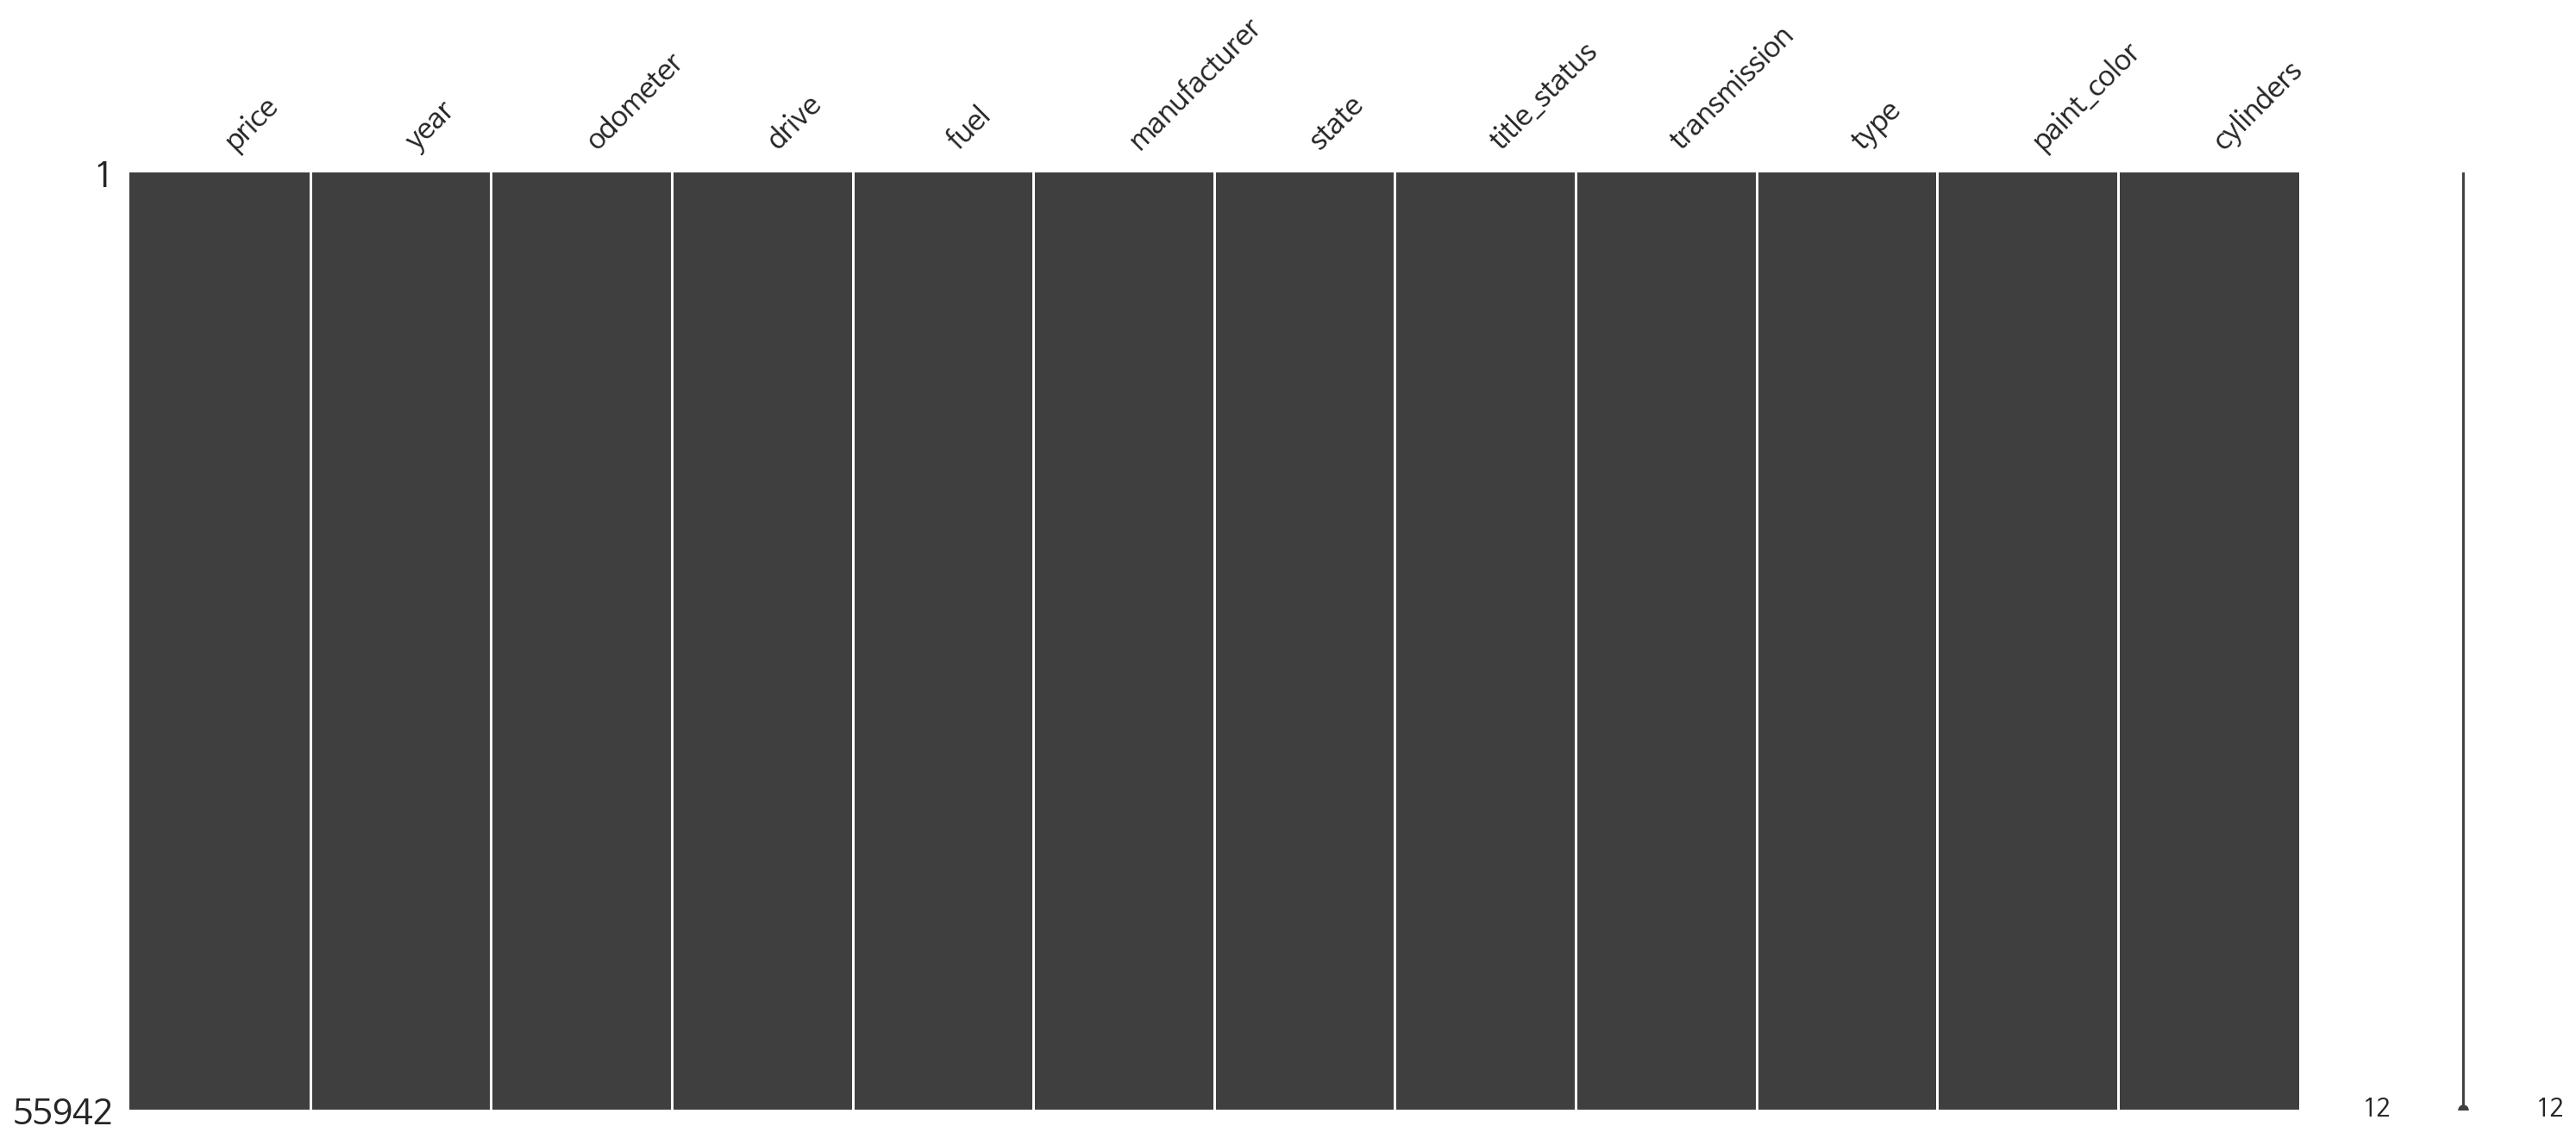

In [350]:
msno.matrix(test2)
plt.show()

### 카테고리 데이터 빈도수에 따른 필터링

In [351]:
def value_counts_filter(num, columns):
    for column in columns:
        result = test2[column].value_counts()[test2[column].value_counts().sort_values(ascending=True) < num]
        if len(result) !=0:
            print(result,end="\n\n===========\n\n")

In [352]:
value_counts_filter(10,test2.columns.difference(['price','odometer','year']))

12 cylinders    2
Name: cylinders, dtype: int64


tesla              9
alfa-romeo         7
harley-davidson    4
porche             2
land rover         2
ferrari            1
aston-martin       1
Name: manufacturer, dtype: int64


missing       4
parts only    3
Name: title_status, dtype: int64


bus    4
Name: type, dtype: int64




In [353]:
def delete_under_ten():
    
    result = test2[test2['cylinders'] != '12 cylinders']
    
    result = result[result['type'] != 'bus']
    
    result = result[(result['title_status'] != 'parts only') & (result['title_status'] != 'missing')]
    
    result = result[(result['manufacturer'] != 'ferrari') & (result['manufacturer'] != 'porche') & (result['manufacturer'] != 'land rover') & (result['manufacturer'] != 'harley-davidson') ]
    
    result = result[(result['manufacturer'] != 'tesla')]
    
    result = result[(result['manufacturer'] != 'alfa-romeo') & (result['manufacturer'] != "aston-martin") ]
    return result

In [354]:
test2 = delete_under_ten()
test2.shape

(55903, 12)

## 변수탐색

### 종속변수 - 가격(price)

In [355]:
test2.price.sort_values(ascending=False)[:20]

60128    193982
29627    139995
20351    121995
73531    109995
14452    103999
62067     92991
29787     89995
16013     89800
61873     82991
29598     80905
77616     79997
56725     79995
13131     79990
19853     79970
65025     78900
14172     77500
30832     76993
41752     76525
23913     75999
30753     75977
Name: price, dtype: int64

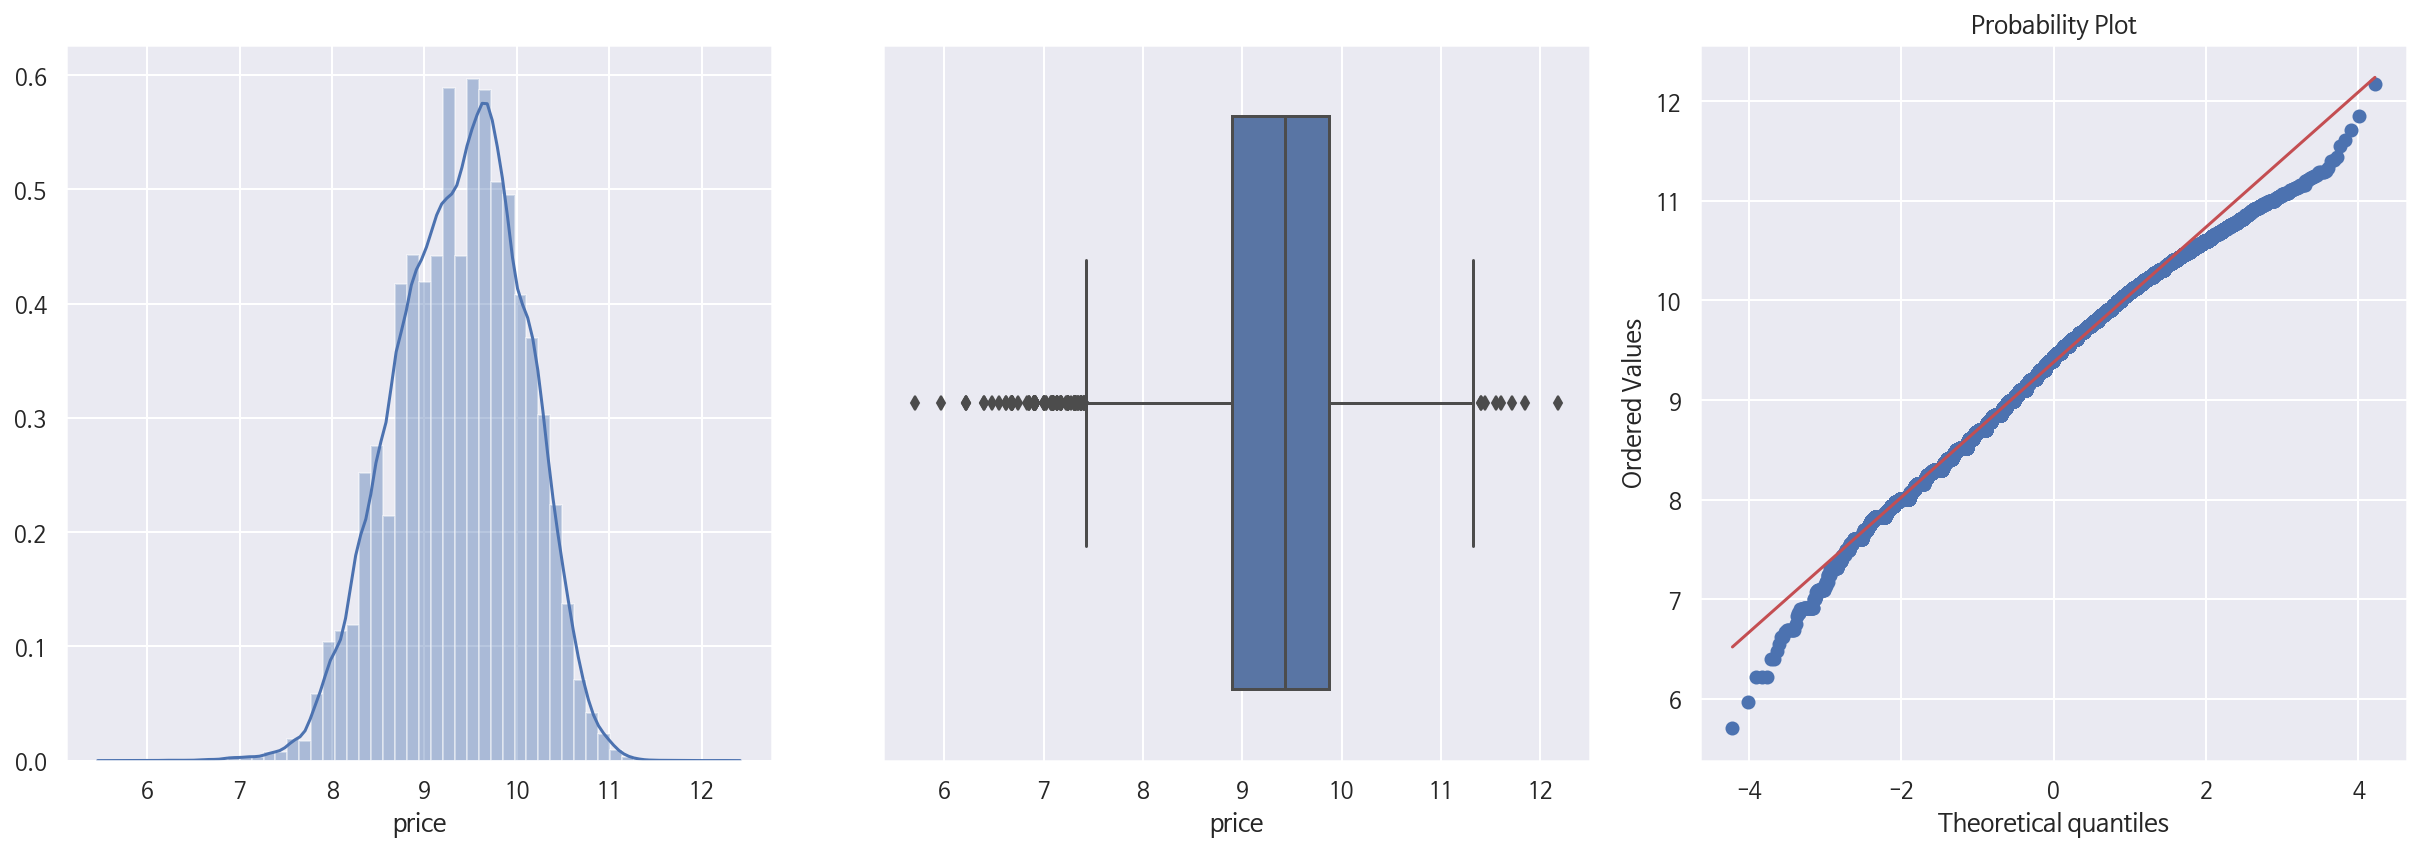

In [356]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(np.log(test2['price']))

plt.subplot(132)
sns.boxplot(np.log(test2['price']))

plt.subplot(133)
stats.probplot(np.log(test2['price']),plot=plt)
plt.tight_layout()
plt.show()

# 독립변수

### 연식

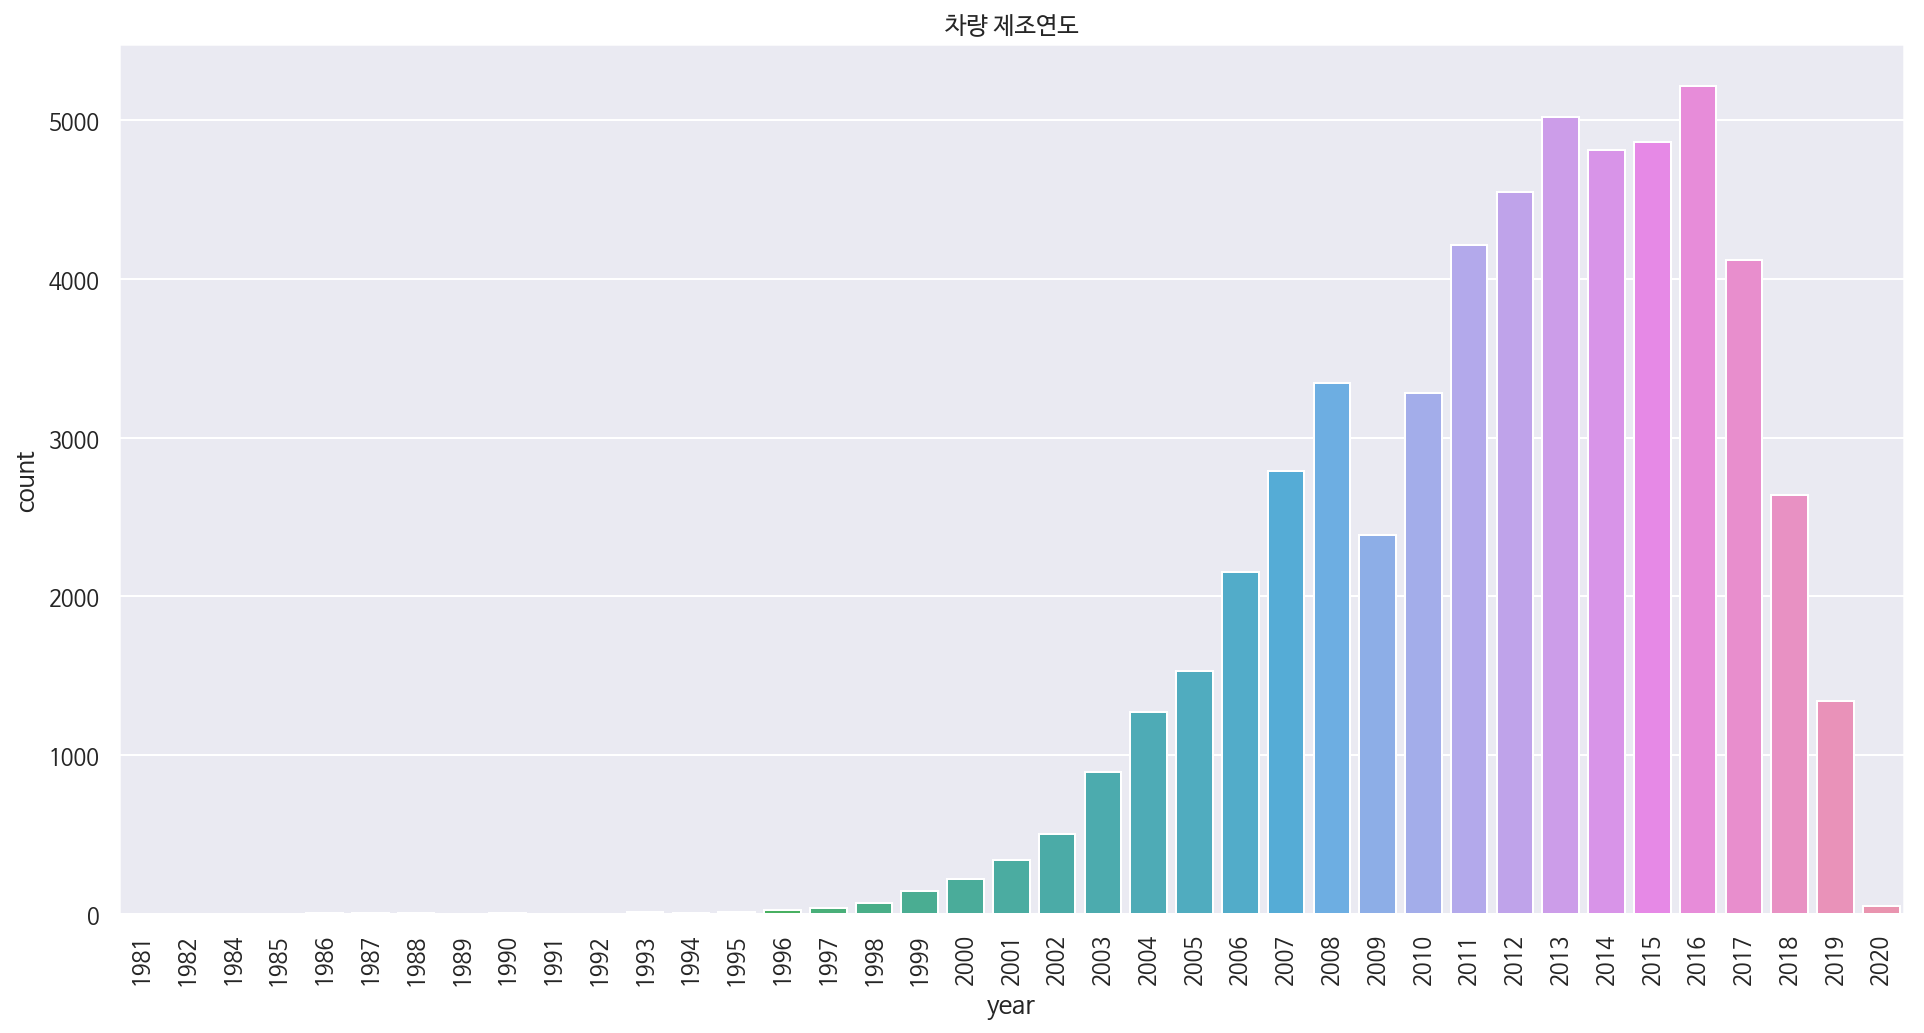

In [357]:
plt.figure(figsize=(16,8))
sns.countplot(
    test2['year']
)
plt.title("차량 제조연도")
plt.xticks(rotation=90)
plt.show()

### 주행거리

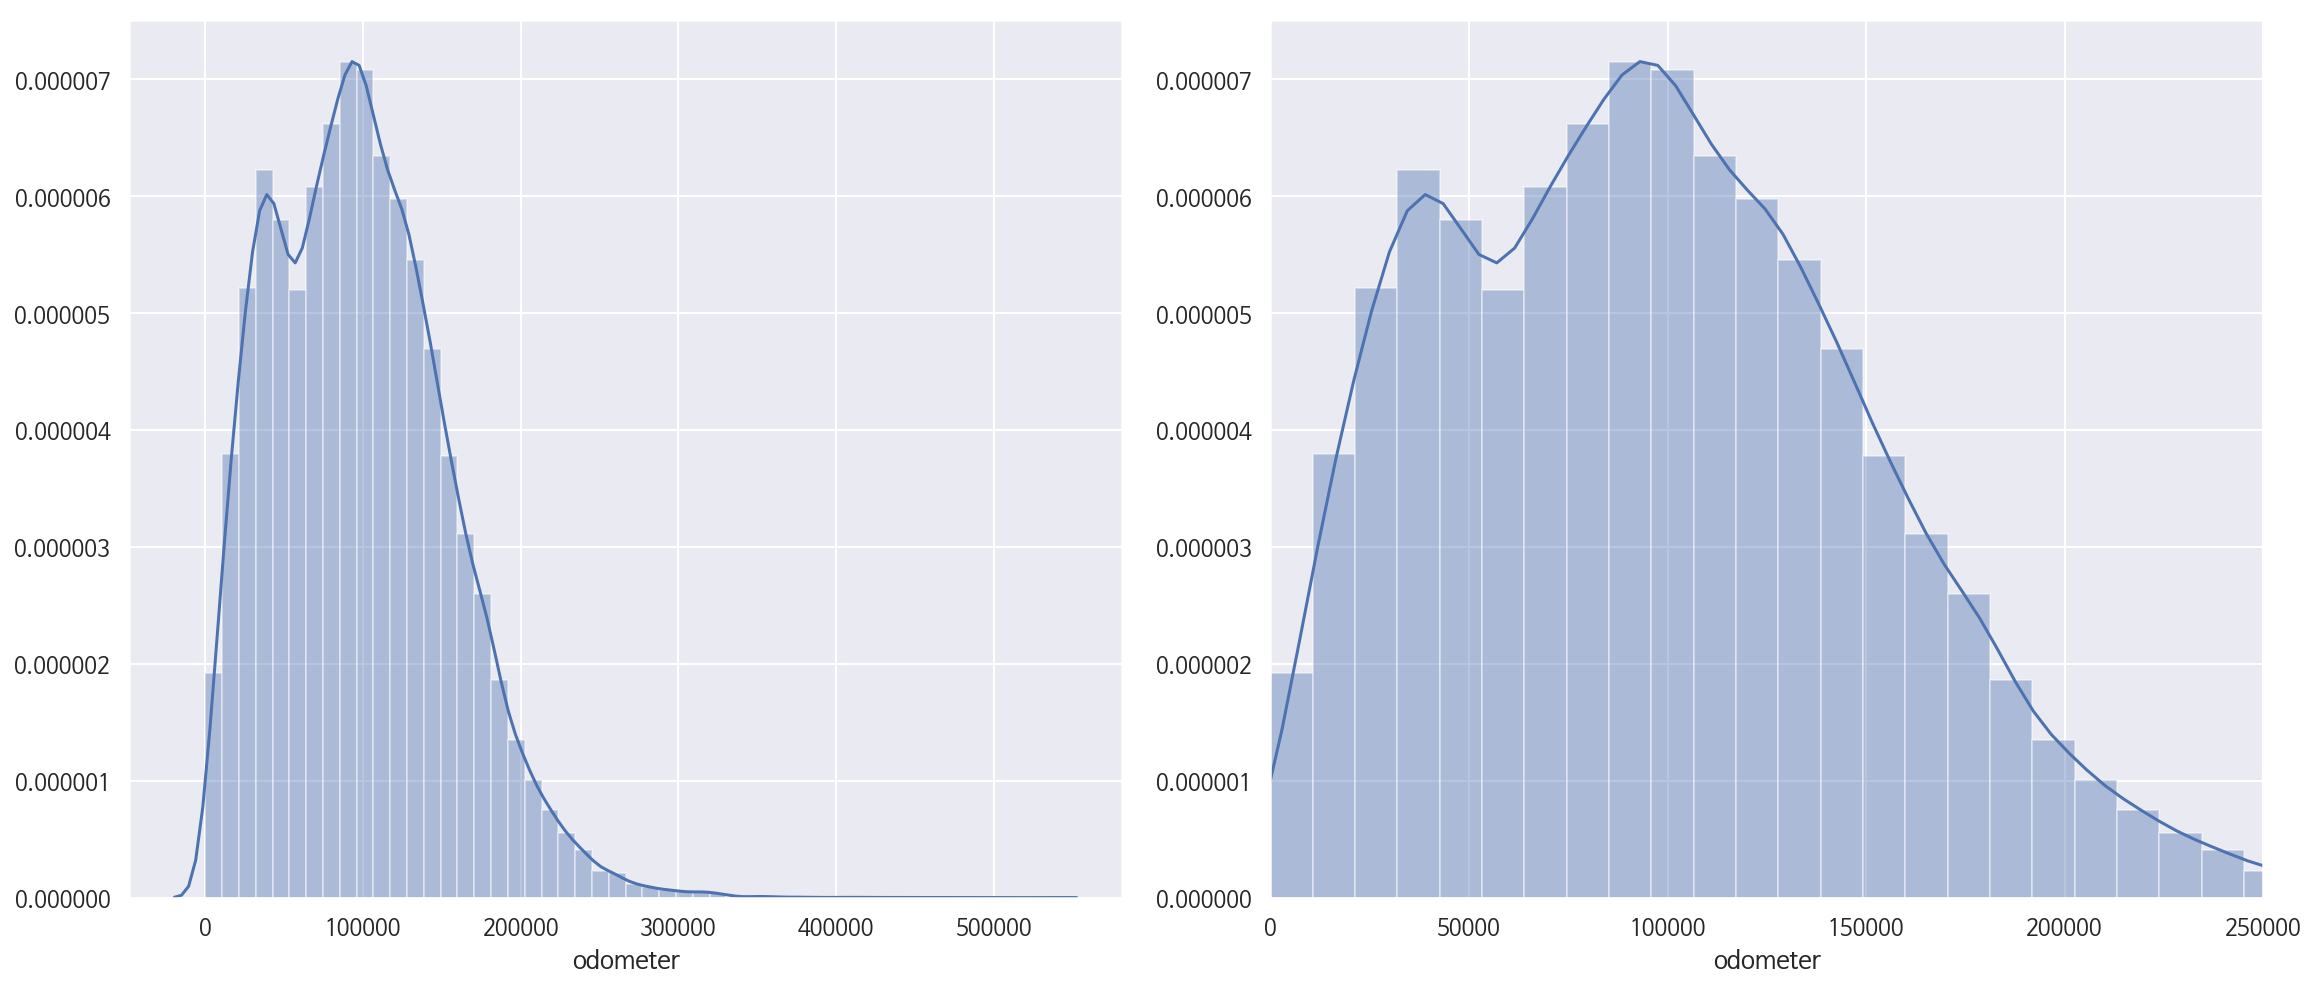

In [358]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.distplot(test2['odometer'])
plt.subplot(122)
sns.distplot(test2['odometer'])
plt.tight_layout()
plt.xlim(0,250000)
plt.show()

### 카테고리 독립변수 확인

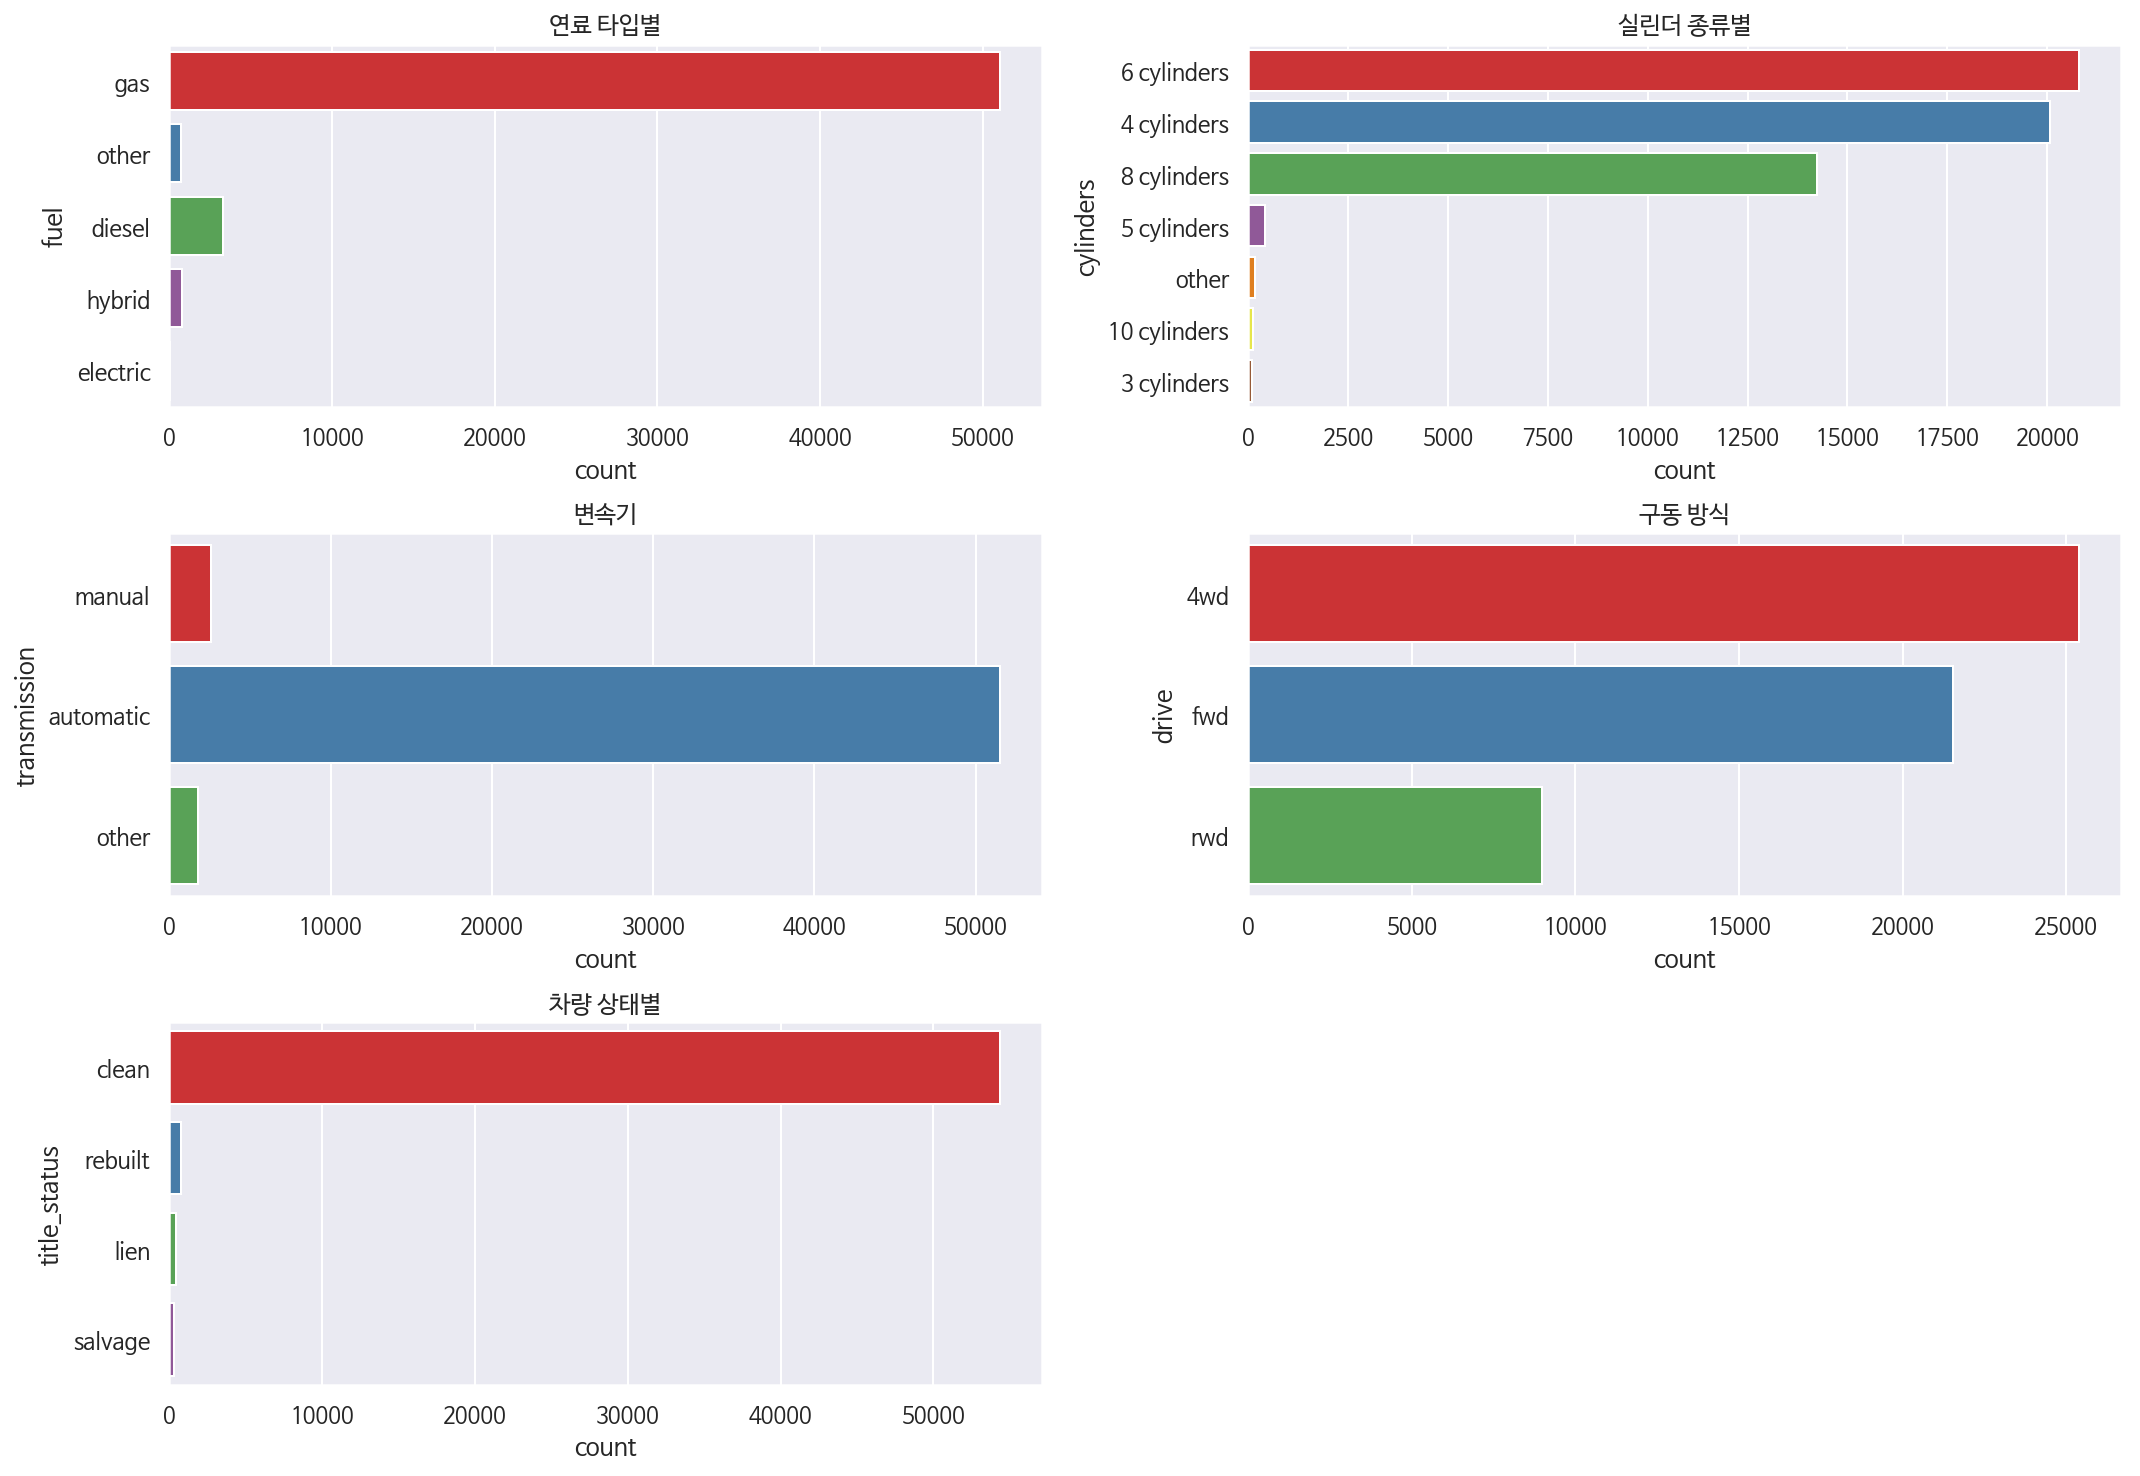

In [359]:
plt.figure(figsize=(15,20))
plt.subplot(621)
sns.countplot(
    data = test2,
    y = "fuel",
    palette='Set1',
)
plt.title("연료 타입별")


plt.subplot(622)
sns.countplot(
    data = test2,
    y = "cylinders",
    palette='Set1',
    order = test2['cylinders'].value_counts().index

)
plt.title("실린더 종류별")


plt.subplot(623)
sns.countplot(
    data = test2,
    y = "transmission",
    palette='Set1'
)
plt.title("변속기")

plt.subplot(624)
sns.countplot(
    data = test2,
    y = "drive",
    palette='Set1'
)
plt.title("구동 방식")


plt.subplot(625)
sns.countplot(
    data = test2,
    y = "title_status",
    palette='Set1'
)
plt.title("차량 상태별")


plt.tight_layout()
plt.show()


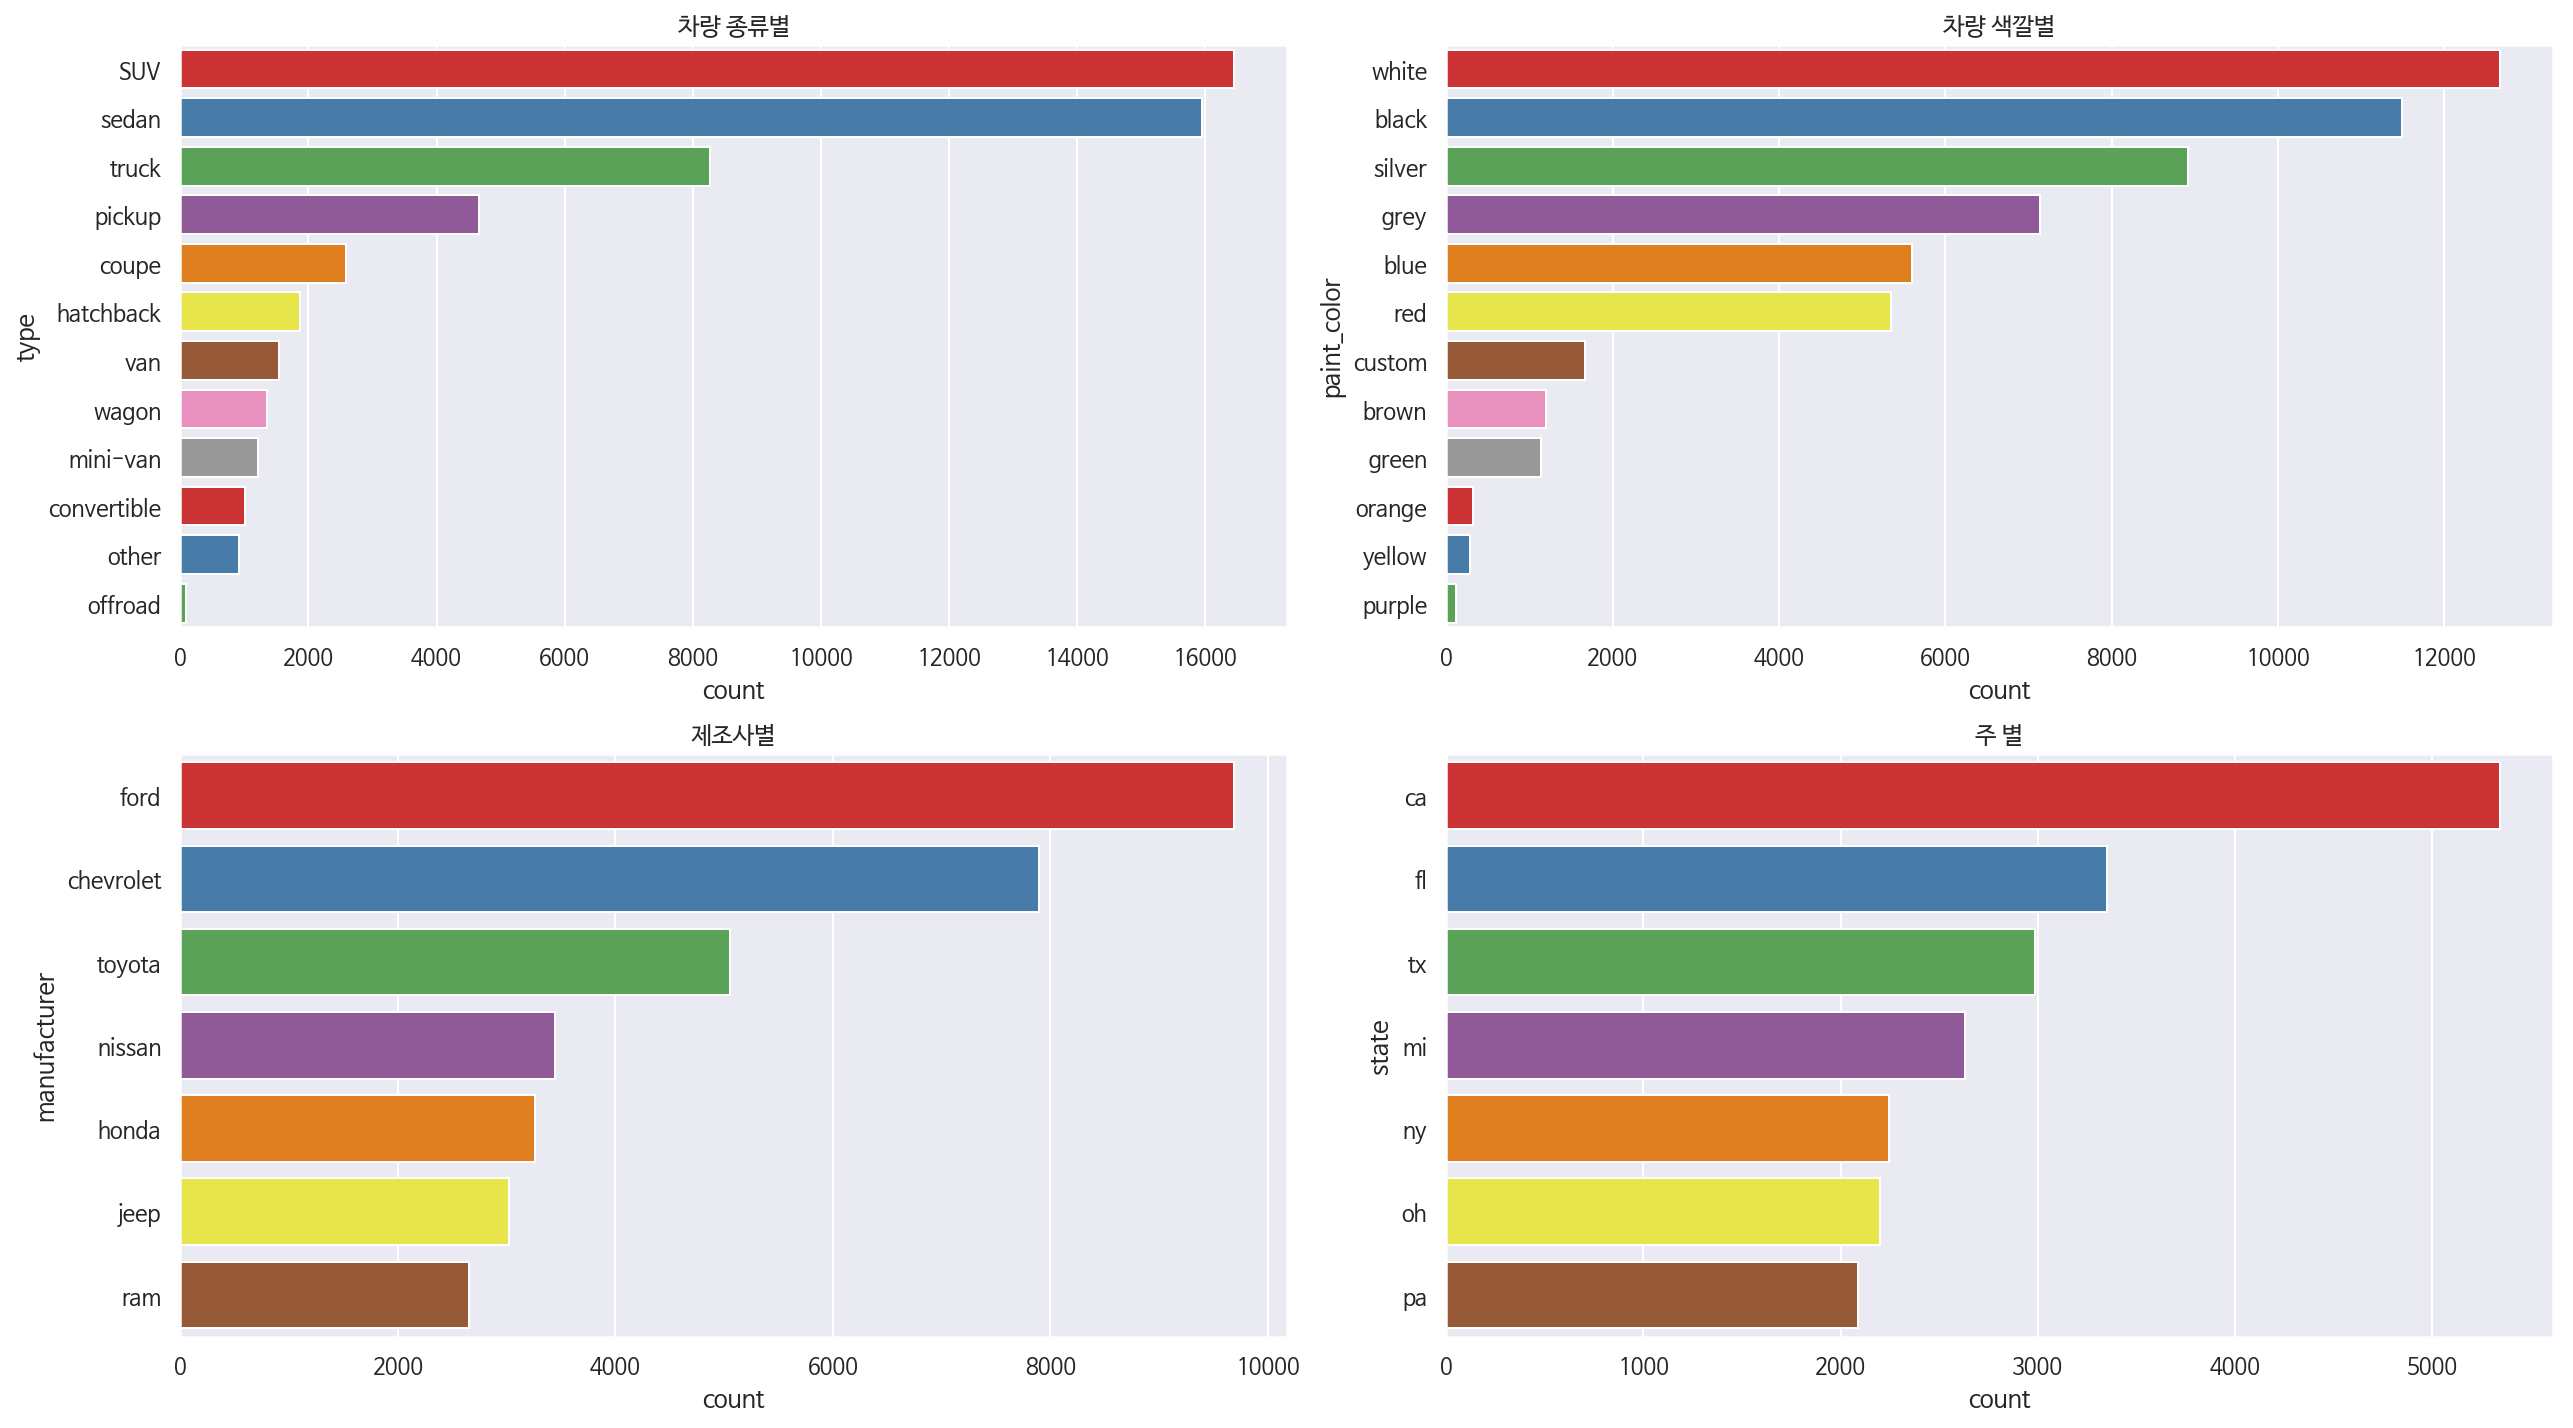

In [360]:
plt.figure(figsize=(18,10))

plt.subplot(221)
sns.countplot(
    data = test2,
    y = "type",
    palette='Set1',
    order = test2['type'].value_counts().index
)
plt.title("차량 종류별")


plt.subplot(222)
sns.countplot(
    data = test2,
    y = "paint_color",
    palette='Set1',
    order = test2['paint_color'].value_counts().index

)
plt.title("차량 색깔별")

plt.subplot(223)
sns.countplot(
    data = test2,
    y = "manufacturer",
    palette='Set1',
    order = test2['manufacturer'].value_counts().iloc[:7].index,

)
plt.title("제조사별")

plt.subplot(224)
sns.countplot(
    data = test2,
    y = "state",
    palette='Set1',
    order = test2['state'].value_counts().iloc[:7].index
)
plt.title("주 별")
plt.tight_layout()
plt.show()

##  변수 상관분석

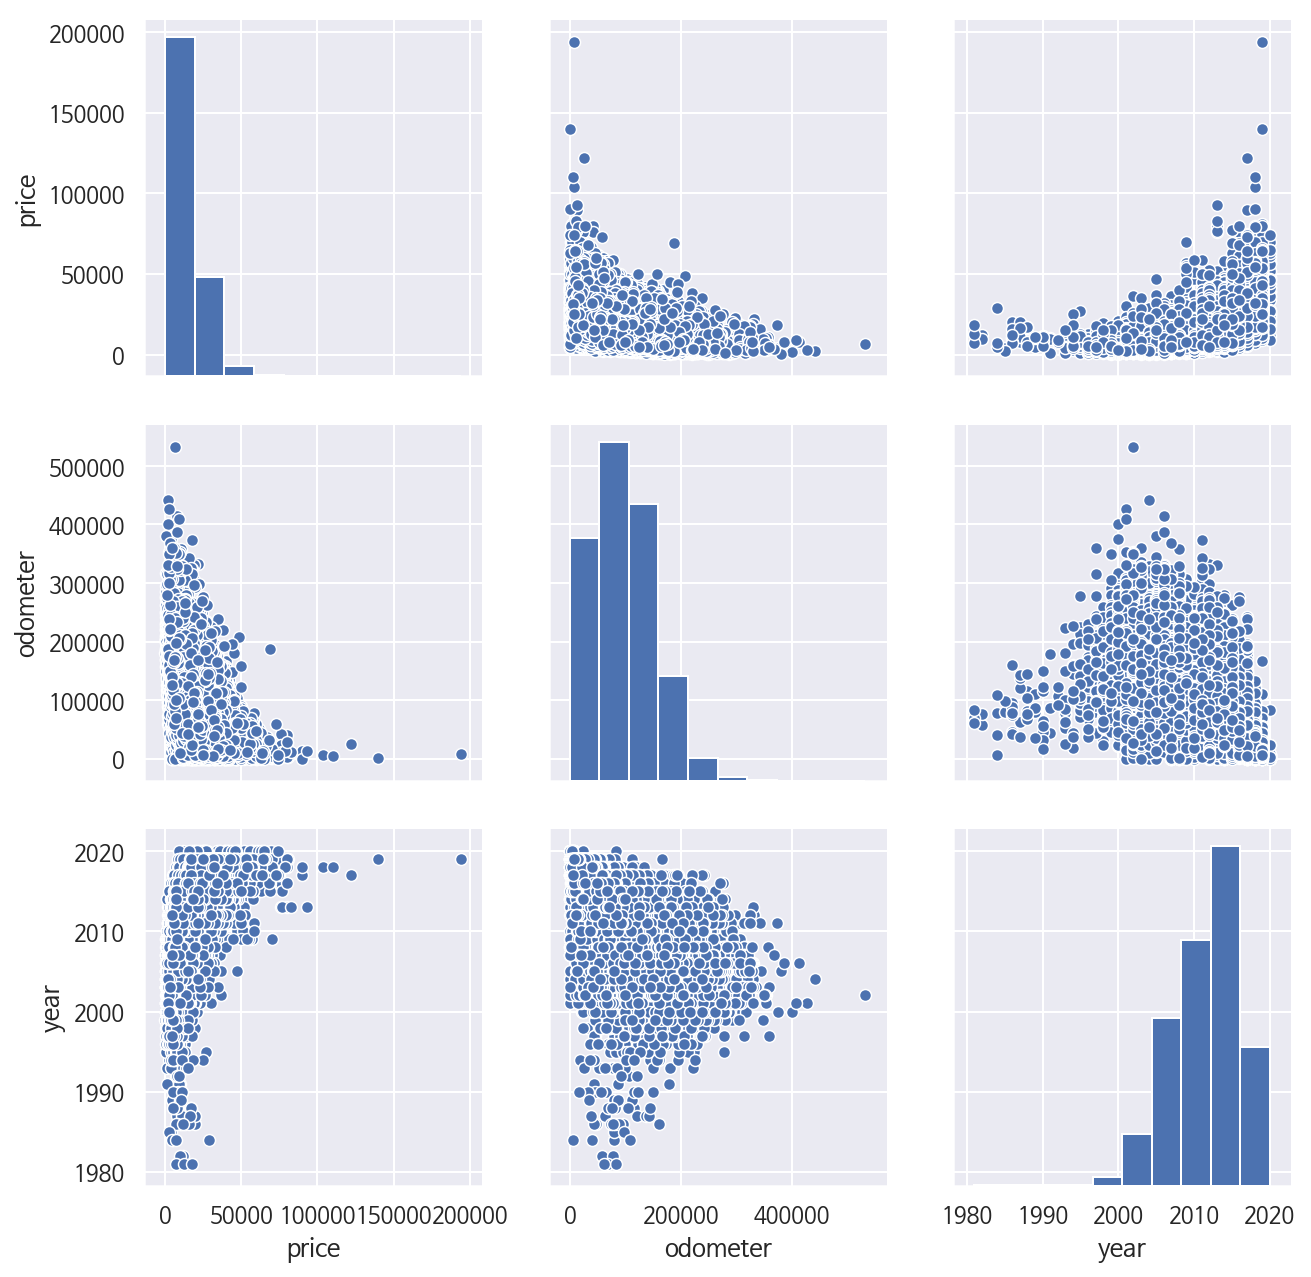

In [361]:
sns.pairplot(test2[['price','odometer','year']],size=3)
plt.show()

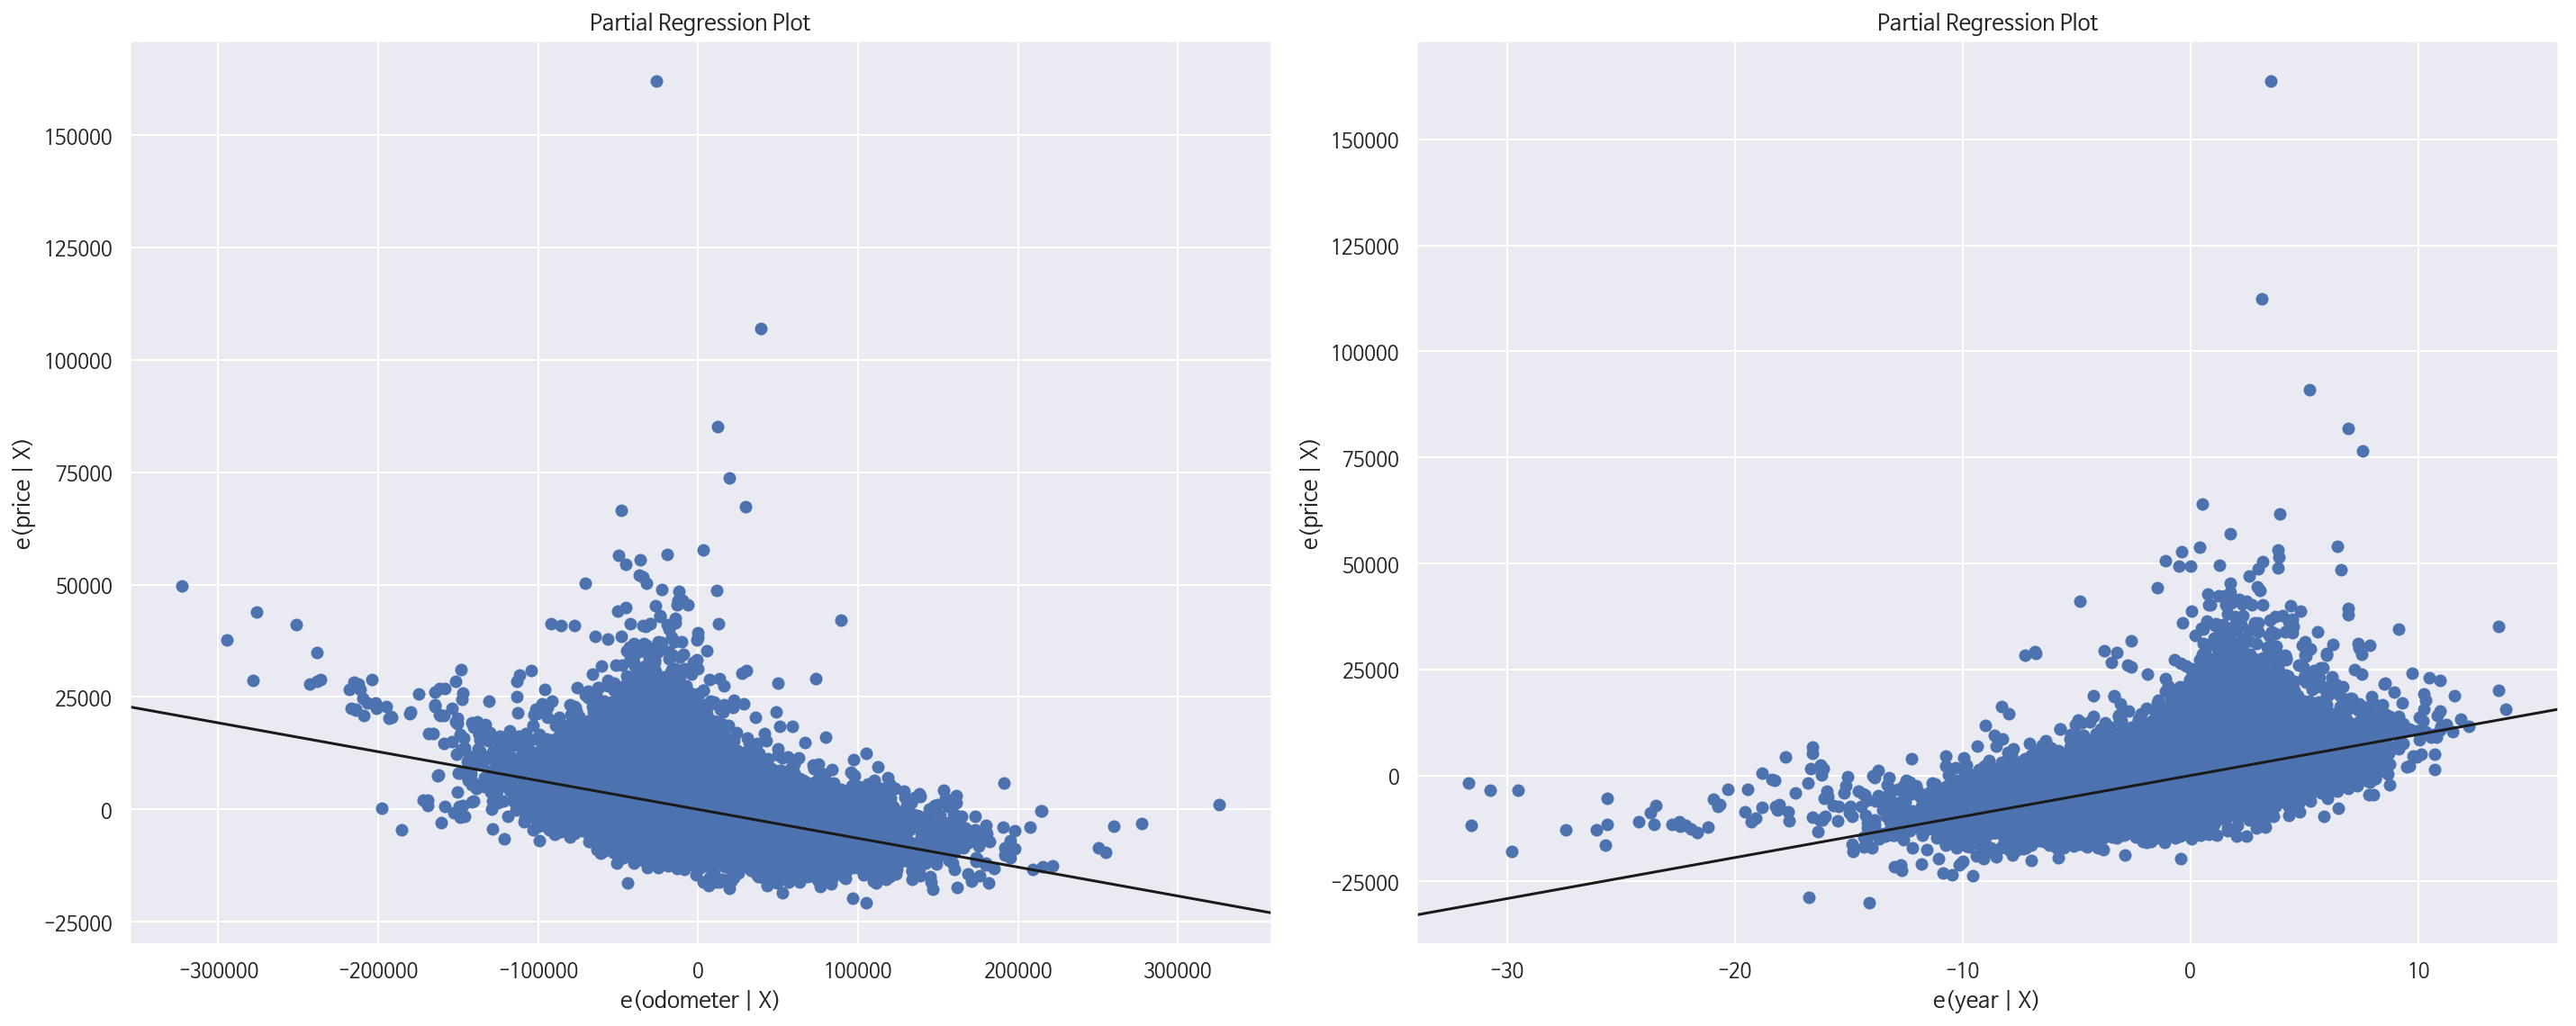

In [362]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


others = list(set(test2.columns).difference(set(["price", "odometer"])))
p, resids = sm.graphics.plot_partregress(
    "price", "odometer", others, data=test2, obs_labels=False, ret_coords=True, ax = ax1
)


others2 = list(set(test2.columns).difference(set(["price", "year"])))
p, resids = sm.graphics.plot_partregress(
    "price", "year", others2, data=test2, obs_labels=False, ret_coords=True, ax = ax2
)
plt.tight_layout()
plt.show()

# Train, Test 데이터 분할
- Train : 80%
- Test : 20%

In [363]:
test2, test_data = train_test_split(test2, test_size = .20, random_state = 7)
test2.shape, test_data.shape

((44722, 12), (11181, 12))

# 모델

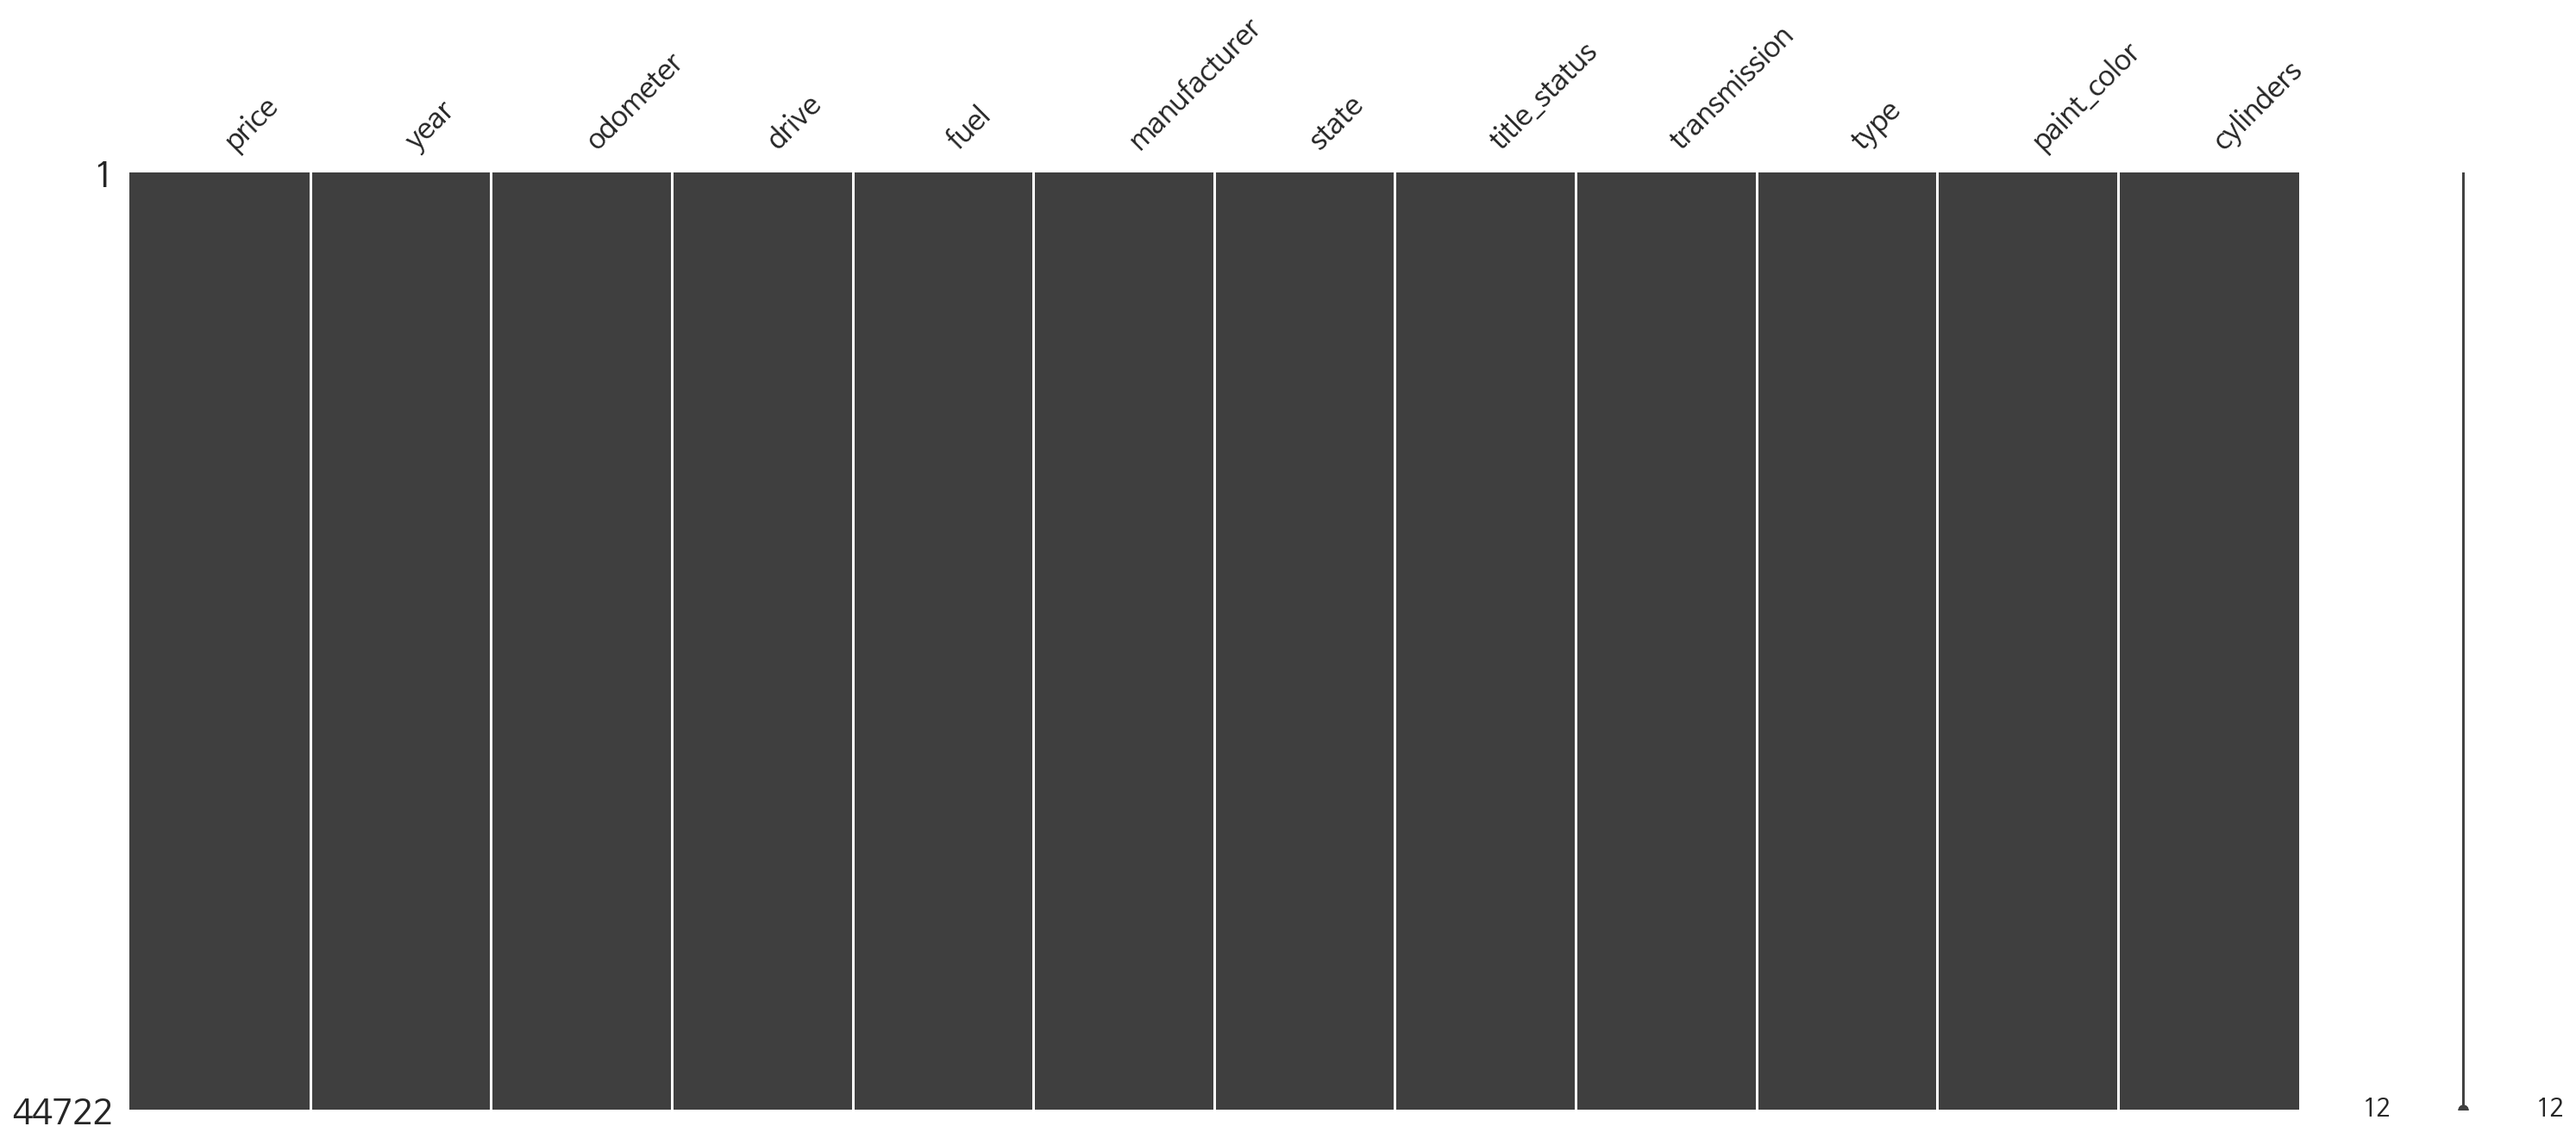

In [364]:
msno.matrix(test2)
plt.show()

### LinearRegression
- train, test 데이터 분류
- test size : 0.2
- 종속변수인 가격에 log를 씌움

Test R2 score :  0.8566707569031964
RMSE of Train Data :  0.25757784910535764
RMSE of Test Data :  0.25853161631845145
K-fold :  [0.8553394  0.85625577 0.85704251 0.85646427 0.85504864]


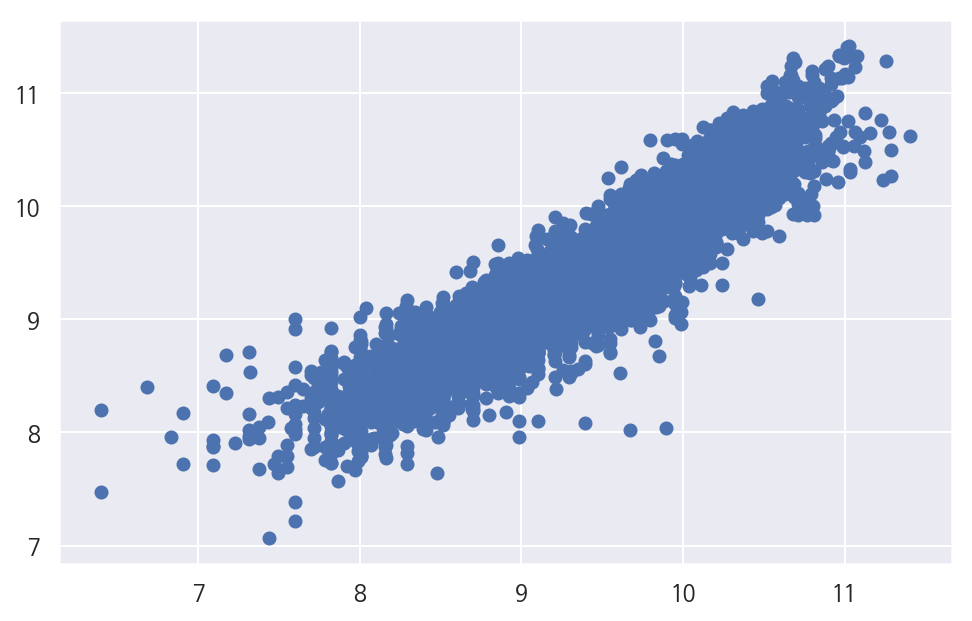

In [365]:
X = test2[test2.columns.difference(['id_x','model','vin','price'])]
Y = np.log(test2['price'])
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 7)

test_df = pd.concat([Y_train,X_train],axis=1)

model = linear_model.LinearRegression() 
result = model.fit(X_train, Y_train)
predicted = result.predict(X_test)
print('Test R2 score : ',r2_score(Y_test,predicted))
plt.scatter(Y_test,predicted)


pred_tr = result.predict(X_train)
pred_test = result.predict(X_test)
rmse_tr = (np.sqrt(mean_squared_error(Y_train, pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(Y_test, pred_test)))


# cv = KFold(10, shuffle=True, random_state=0)
a = cross_val_score(model, X, Y, scoring=None, cv=5)

print('RMSE of Train Data : ', rmse_tr)
print('RMSE of Test Data : ', rmse_test)
print('K-fold : ',a)

### sm.OLS.from_formula
- train, test 데이터 분류
- test size : 0.2
- 종속변수인 가격에 log를 씌움

### Model 1
- ```"price ~ scale(odometer) + scale(year) + cylinders + drive + fuel + manufacturer + paint_color + state + title_status + transmission + type"```

In [371]:
X = test2[test2.columns.difference(['price'])]
Y = np.log(test2['price'])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20,random_state=7)

test_df = pd.concat([Y_train,X_train],axis=1)


model1 = sm.OLS.from_formula("price ~ scale(odometer) + scale(year) +{}".format("+".join(test_df.columns.difference(['price','odometer','year'])))+"+0",test_df)
result = model1.fit()
prediction = result.predict(X_test)
print("R2 score : ",r2_score(Y_test,prediction))
print(result.summary())


R2 score :  0.8566707569032072
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1736.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        00:57:24   Log-Likelihood:                -2236.3
No. Observations:               35777   AIC:                             4721.
Df Residuals:                   35653   BIC:                             5773.
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### 교차 검증

In [274]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm

class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self, formula):
        self.formula = formula
        self.model = None
        self.data = None
        self.result = None
        
    def fit(self, dfX, dfy):
        self.data = pd.concat([dfX, dfy], axis=1)
        self.model = smf.ols(self.formula, data=self.data)
        self.result = self.model.fit()
        
    def predict(self, new_data):
        return self.result.predict(new_data)

### k-fold  검증

In [367]:
# 10개 미만의 데이터 지우고 나서는 부트스트래핑 하지 않아도 잘됨
model1 = StatsmodelsOLS("price ~ scale(odometer) + scale(year) +{}".format("+".join(test2.columns.difference(['price','odometer','year'])))+"+0")

dfX = test2[test2.columns.difference(['price'])]
dfy = np.log(test2['price'])
cv = KFold(10, shuffle=True, random_state=7)
model_1_cross_val_score = cross_val_score(model1, dfX, dfy, scoring="r2", cv=cv)
model_1_cross_val_score

array([0.86098991, 0.85262504, 0.85654524, 0.85716713, 0.85664975,
       0.85441733, 0.85141133, 0.86080941, 0.85177199, 0.85801401])

### Model 1
- ```"price ~ scale(odometer) + scale(year) + cylinders + drive + fuel + manufacturer + paint_color + state + title_status + transmission + type"```

### Model 2
- ```"price ~ scale(odometer) + scale(year) + cylinders + drive + fuel + manufacturer + paint_color + state + title_status + transmission + type + scale(year):C(cylinders)+ scale(odometer): C(fuel) + scale(year):C(fuel) + scale(odometer): C(drive) + scale(year):C(drive)"```

# ANOVA를 통한 독립변수 점검

In [276]:
anova = sm.stats.anova_lm(result, typ=2)
anova.sort_values(by=['F'],ascending=False)

,sum_sq,df,F,PR(>F)
cylinders,19041.05532,7.00000,40619.66987,0.00000
scale(year),1783.20642,1.00000,26628.39771,0.00000
scale(odometer),1109.58719,1.00000,16569.32622,0.00000
fuel,445.25248,4.00000,1662.22485,0.00000
drive,175.43599,2.00000,1309.88184,0.00000
type,174.82448,11.00000,237.33018,0.00000
manufacturer,395.34031,32.00000,184.48648,0.00000
transmission,19.48720,2.00000,145.49996,0.00000
title_status,19.40066,3.00000,96.56921,0.00000
state,90.26468,50.00000,26.95822,0.00000


### sm.OLS.from_formula
- train, test 데이터 분류
- test size : 0.2
- 종속변수인 가격에 log를 씌움

In [391]:
X = test2[test2.columns.difference(['price'])]
Y = np.log(test2['price'])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20,random_state=0)

test_df = pd.concat([Y_train,X_train],axis=1)

model2 = sm.OLS.from_formula("price ~ scale(odometer) + scale(year) + scale(odometer): C(cylinders)+ scale(year):C(cylinders)+ scale(odometer): C(fuel) + scale(year):C(fuel) + scale(odometer): C(drive) + scale(year):C(drive) +{}".format("+".join(test2.columns.difference(['price','odometer','year'])))+"+0",test_df)
result = model2.fit()
pred = result.predict(X_test)

print("R2 score : ",r2_score(Y_test,pred))
print(result.summary())

R2 score :  0.8692978908552522
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1584.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        01:11:31   Log-Likelihood:                -958.03
No. Observations:               35777   AIC:                             2212.
Df Residuals:                   35629   BIC:                             3468.
Df Model:                         147                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

### k-fold  검증

In [392]:
# 부트스트래핑 하지 않은 검증
model2 = StatsmodelsOLS("price ~ scale(odometer) + scale(year) + scale(odometer): C(cylinders)+ scale(year):C(cylinders)+ scale(odometer): C(fuel) + scale(year):C(fuel) + scale(odometer): C(drive) + scale(year):C(drive) +{}".format("+".join(test2.columns.difference(['price','odometer','year'])))+"+0")

dfX = test2[test2.columns.difference(['price'])]
dfy = np.log(test2['price'])
cv = KFold(10, shuffle=True, random_state=7)
model_2_cross_val_score = cross_val_score(model2, dfX, dfy, scoring="r2", cv=cv)
model_2_cross_val_score

array([0.87064694, 0.86393903, 0.86896218, 0.86639472, 0.8692138 ,
       0.86564423, 0.86200723, 0.86847583, 0.86120848, 0.8704211 ])

# k-fold 검증 성능 비교

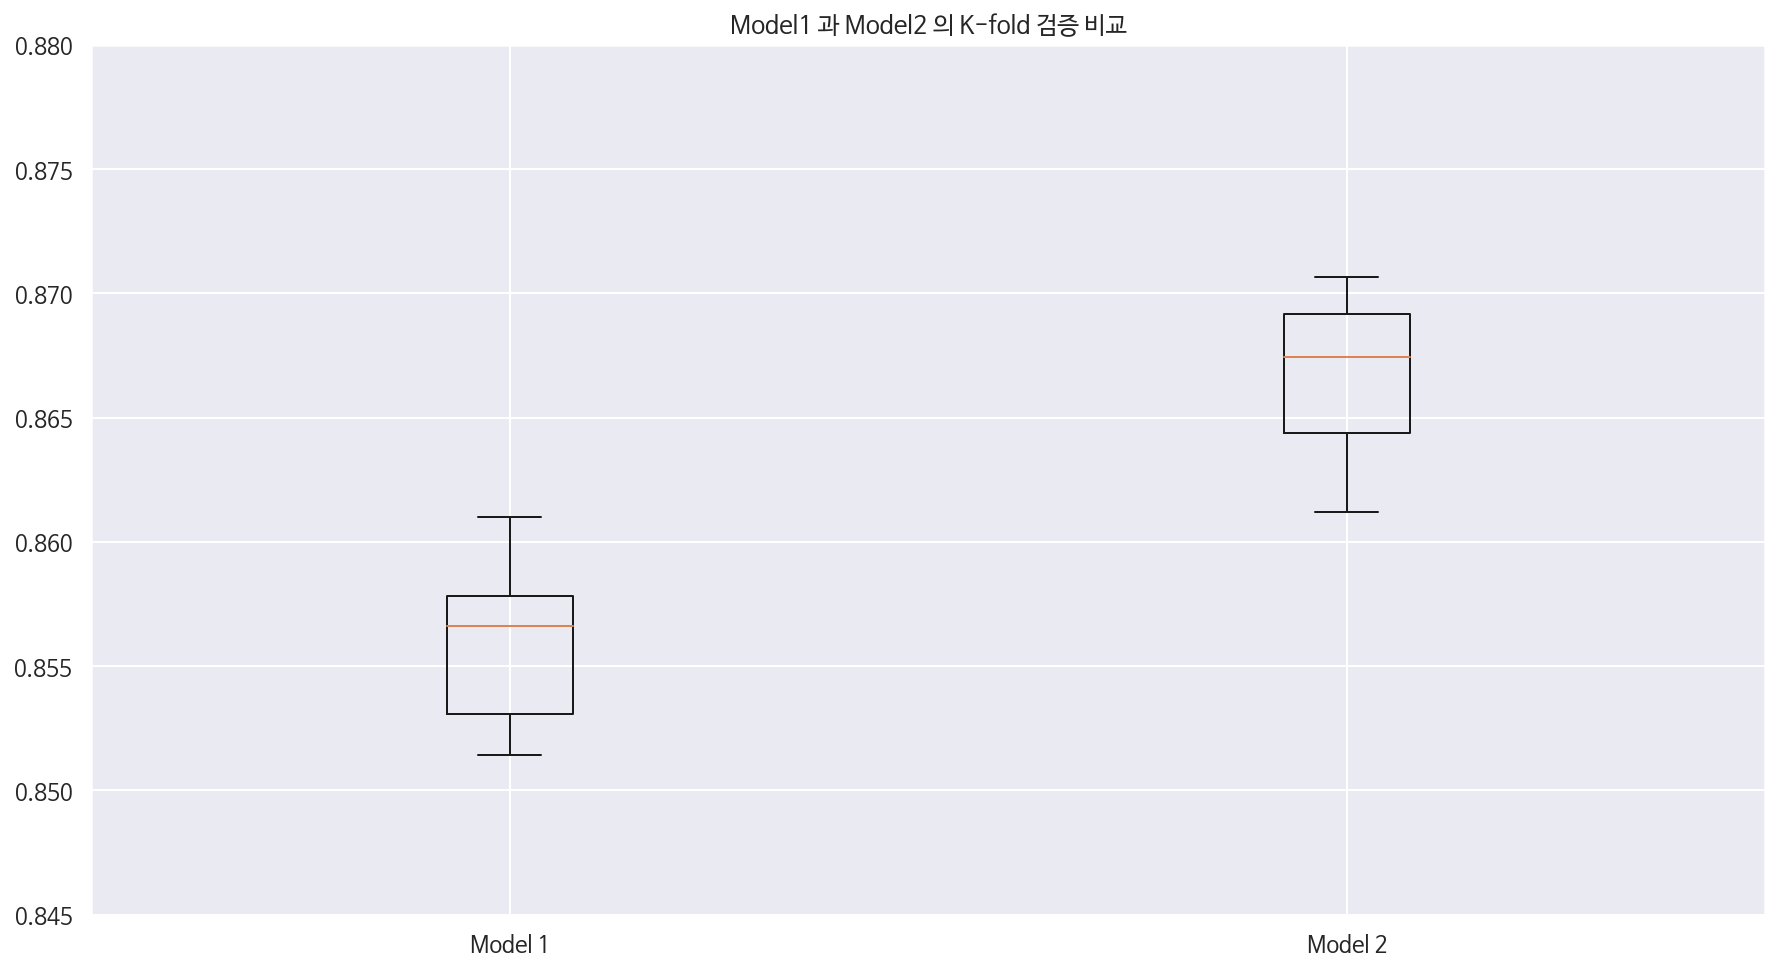

In [408]:
fig, ax = plt.subplots(figsize=(15,8))

ax.boxplot([model_1_cross_val_score, model_2_cross_val_score], sym="b*", labels=['Model 1', 'Model 2'],)
plt.ylim(0.845,0.88)
plt.title('Model1 과 Model2 의 K-fold 검증 비교')
plt.show()

# 각 모델별 Test 데이터로 예측한 R-sqaure

In [291]:
X = test2[test2.columns.difference(['price'])]
Y = np.log(test2['price'])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20,random_state=7)

test_df = pd.concat([Y_train,X_train],axis=1)


model1 = sm.OLS.from_formula("price ~ scale(odometer) + scale(year) +{}".format("+".join(test_df.columns.difference(['price','odometer','year'])))+"+0",test_df)
result = model1.fit()
prediction = result.predict(test_data[test_data.columns.difference(['price'])])
print("Model 1 R-sqaure : ", r2_score(np.log(test_data['price']),prediction))

Model 1 R-sqaure :  0.8520564566874587


In [394]:
X = test2[test2.columns.difference(['price'])]
Y = np.log(test2['price'])


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20,random_state=7)

test_df = pd.concat([Y_train,X_train],axis=1)


model1 = sm.OLS.from_formula("price ~ scale(odometer) + scale(year) + scale(odometer): C(cylinders)+ scale(year):C(cylinders)+ scale(odometer): C(fuel) + scale(year):C(fuel) + scale(odometer): C(drive) + scale(year):C(drive) +{}".format("+".join(test2.columns.difference(['price','odometer','year'])))+"+0", test_df)

result = model1.fit()
prediction = result.predict(test_data[test_data.columns.difference(['price'])])
print("Model 2 R-sqaure : ", r2_score(np.log(test_data['price']),prediction))

Model 2 R-sqaure :  0.8625166297047728


# 향후 프로젝트 진행 방향
- 변수간 상관관계 심층 분석
- 모델별 성능 평가
- 가설 증명

## 해결하지 못한 의문점
- 데이터 분할 
  - **Train-Test split** 
  - **K-fold**
  - 부트스트래핑?
- ANOVA
  - 카테고리 독립변수간의 상관관계 분석 방식에 대한 의문

# VIF Factor ???

In [1285]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.00,title_status_parts only
1,1.00,title_status_missing
2,1.01,manufacturer_ferrari
3,1.01,manufacturer_land rover
4,1.01,type_bus
...,...,...
128,20.72,manufacturer_ford
129,170.87,cylinders_8 cylinders
130,222.92,cylinders_4 cylinders
131,241.85,cylinders_6 cylinders


In [1286]:
vif.sort_values(by=['VIF Factor'], ascending=False).iloc[:20]

,VIF Factor,features
132,852.60,year
131,241.85,cylinders_6 cylinders
130,222.92,cylinders_4 cylinders
129,170.87,cylinders_8 cylinders
128,20.72,manufacturer_ford
127,19.97,fuel_gas
126,17.27,manufacturer_chevrolet
125,11.01,manufacturer_toyota
124,7.50,state_ca
123,7.31,manufacturer_jeep


In [66]:
test2.columns

Index(['price', 'year', 'odometer', 'drive', 'fuel', 'manufacturer', 'state',
       'title_status', 'transmission', 'type', 'paint_color', 'cylinders'],
      dtype='object')

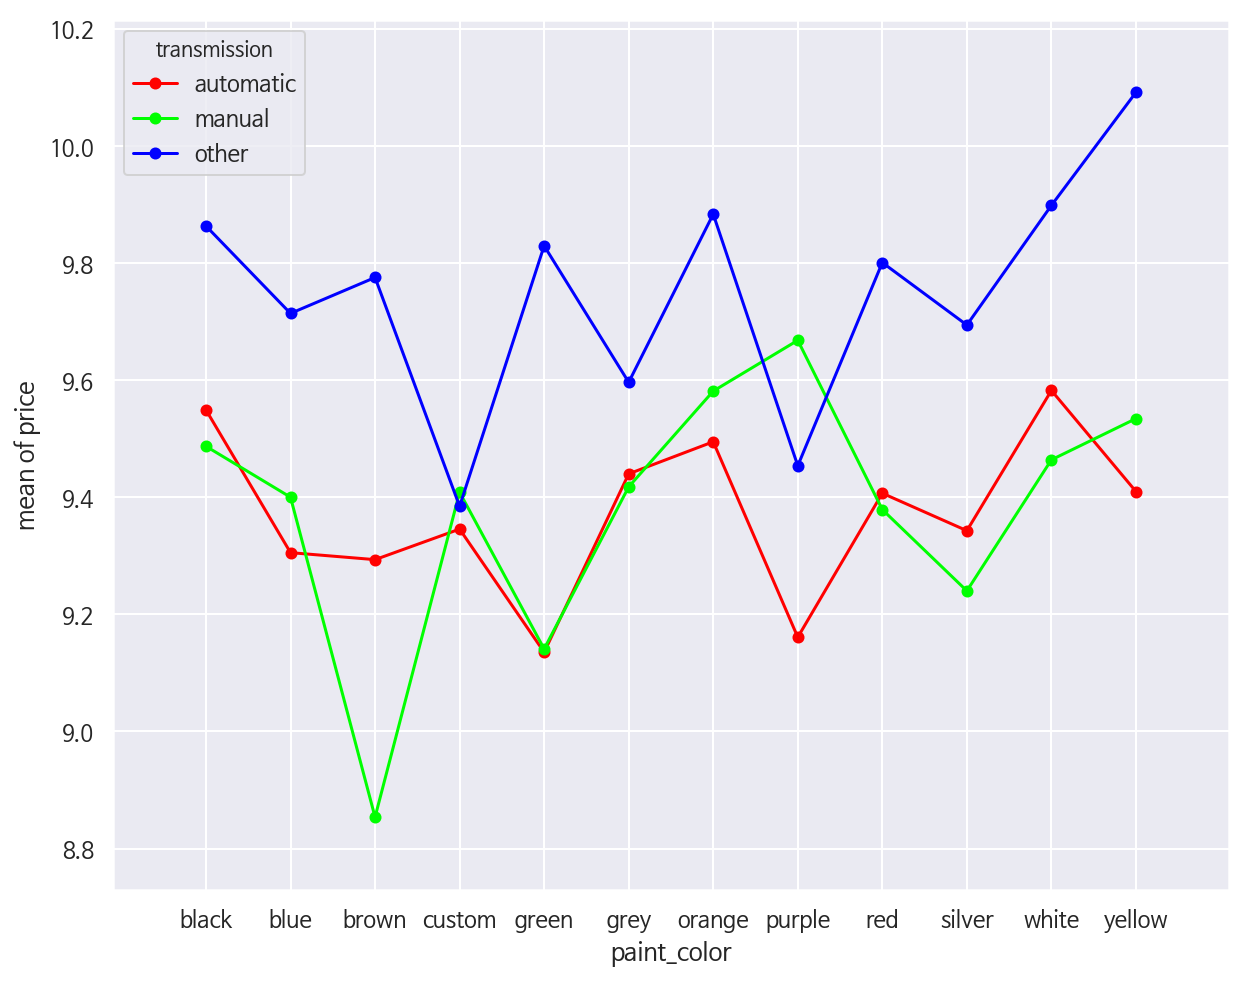

In [75]:
from statsmodels.graphics.api import interaction_plot, abline_plot

plt.figure(figsize=(10,8))
fig = interaction_plot(test2['paint_color'], test2['transmission'], np.log(test2['price']), ms=10, ax=plt.gca())

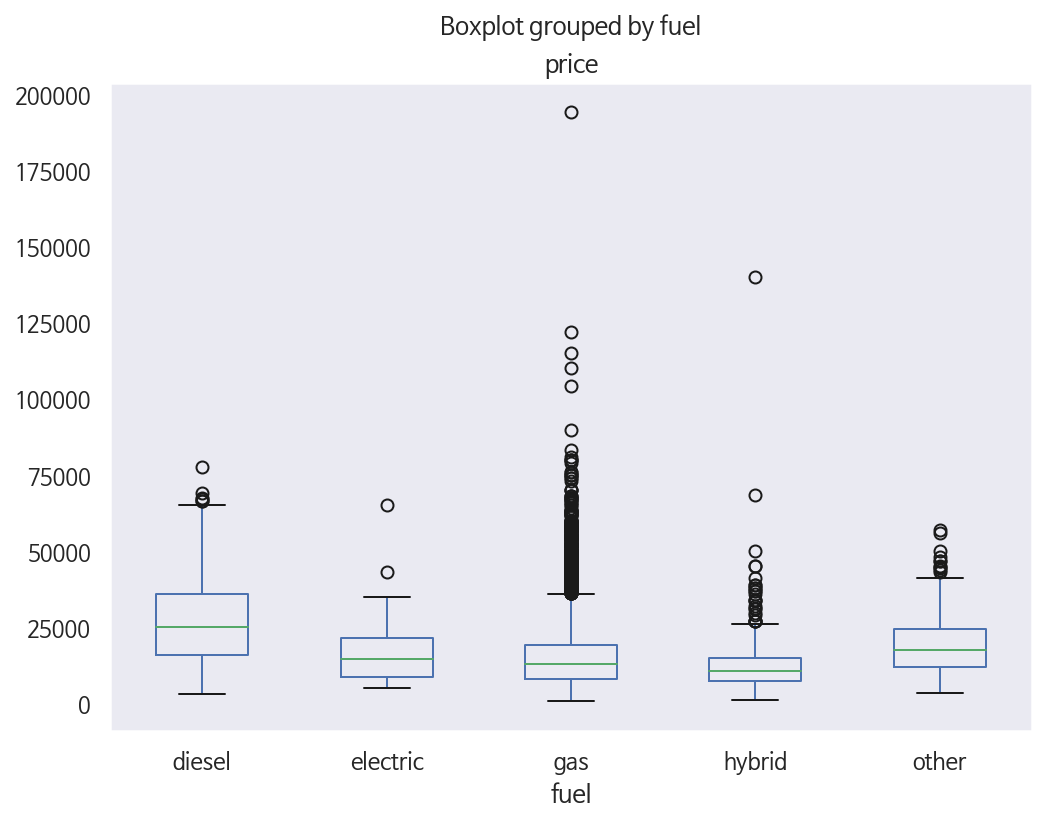

In [80]:
fig, ax = plt.subplots(figsize=(8,6))
fig = test2.boxplot('price', 'fuel', ax=ax, grid=False)

In [82]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

rehab_lm = ols('price ~ C(fuel)', data=test2).fit()
table9 = anova_lm(rehab_lm)
print(table9)

print(rehab_lm.model.data.orig_exog)

               df           sum_sq        mean_sq       F  PR(>F)
C(fuel)      4.00  364697340480.33 91174335120.08 1053.23    0.00
Residual 42561.00 3684347198815.98    86566274.26     nan     nan
       Intercept  C(fuel)[T.electric]  C(fuel)[T.gas]  C(fuel)[T.hybrid]  \
0           1.00                 0.00            1.00               0.00   
3           1.00                 0.00            1.00               0.00   
10          1.00                 0.00            1.00               0.00   
11          1.00                 0.00            1.00               0.00   
12          1.00                 0.00            1.00               0.00   
...          ...                  ...             ...                ...   
77637       1.00                 0.00            1.00               0.00   
77639       1.00                 0.00            1.00               0.00   
77641       1.00                 0.00            1.00               0.00   
77642       1.00                 0.00     

In [83]:
rehab_lm = ols('price ~ C(cylinders)', data=test2).fit()
table9 = anova_lm(rehab_lm)
print(table9)

print(rehab_lm.model.data.orig_exog)

                   df           sum_sq        mean_sq      F  PR(>F)
C(cylinders)     7.00  546047963143.79 78006851877.68 947.71    0.00
Residual     42558.00 3502996576152.51    82311118.38    nan     nan
       Intercept  C(cylinders)[T.12 cylinders]  C(cylinders)[T.3 cylinders]  \
0           1.00                          0.00                         0.00   
3           1.00                          0.00                         0.00   
10          1.00                          0.00                         0.00   
11          1.00                          0.00                         0.00   
12          1.00                          0.00                         0.00   
...          ...                           ...                          ...   
77637       1.00                          0.00                         0.00   
77639       1.00                          0.00                         0.00   
77641       1.00                          0.00                         0.00   
776

# 변수간 상관관계

# 모델별 성능 평가

# 가설 증명

# 데이터 한번에 불러오는 함수

In [138]:
def get_data_by_sigma(num):
    global test2
    test2 = test[(test['price'] >= (test['average'] - (test['stdev']*num))) & (test['price'] <= (test['average'] + (test['stdev']*num)))]
    
    test2 = test2[test2['mileage'] == test2['odometer']]
    
    test2['year'] = test2['year'].apply(lambda x : 2019 if x < 1980 else x)
    
    test2= test2[test2['odometer'] != 0]
    
    test2= test2[test2['price'] != 0]
    
    test2 = test2[['price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders']]
    print("{} sigma data : ".format(num),test2.shape)

In [ ]:
# 더미 변수화 하면서 오류 발생 시키는 카테고리 값들 수정하기
for column in test2.columns.difference(['price','mileage','year']):
    test2[column] = test2[column].apply(lambda x : x.replace("-","").replace(" ","") if "-" or " " in x else x)
test2['cylinders'] = test2['cylinders'].str.get(0)